# This notebook shows the experiments related to dual-code enhancers
#### The cloned enhancers fasta file from Janssens et al is provided in ./data/augmentation_pruning
#### The notebook consists of:
* Performing mutations on genomic enhancers to add a second code
* Identifying genomic enhancers accessible in two or more cell lines
* Performing mutations on genomic enhancers to remove the second code
#### Figures are saved to ./figures/augmentation_pruning folder

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the model and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading genomic enhancer sequences studied in Janssens et al.

In [5]:
def prepare_data_wolabel_difsize(filename):
    ids, ids_d, seqs = utils.readfile(filename)
    X = ([utils.one_hot_encode_along_row_axis(seqs[id]) for id in ids_d])
    ids = np.array([id for id in ids_d])
    result = {'ids':ids, 'X':X}
    return result 

cloned_enhancers_dict = prepare_data_wolabel_difsize('data/augmentation_pruning/Janssens_et_al_enhancers.fa')
upstream_seq = utils.one_hot_encode_along_row_axis("ACCCAATAAAAGATTATTATATTGCATACCCGTTTTTAATAAAATACATTGCATACCCTCTTTTAATAAAAAATATTGCATACGTTGACGAAACAAATTTTCGTTGCATACCCAATAAAAGATTATTATATTGCATACCTTTTCTTGCCATACCATTTAGCCGATCAATTGTGCTCGGCAACAGCATGCTGCAGCAGATC")
downstream_seq = utils.one_hot_encode_along_row_axis("AAATAGAGGCGCTTCGTCTACGGAGCGACAATTCAATTCAAACAAGCAAAGTGAACACGTCGCTAAGCGAAAGCTAAGCAAATAAACAAGCGCAGCTGAACAAGCTAAACAATCTGCAGCCAAGCTGATCCTCTAGGGTACGCGCTAGAGTCGAGAGGCCTGTTTAAACGATCCACCGGTCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGAGCAGGCACAGAAGGCATCGCCAGCGCTCTAGGAGCCGCAATCGCAGCCGAAGTCGCAGCAGTGAACGAAAACGCCGTCAACGGAGCCGAAGTCGCAGCAGTGAACGAAGACGCTAACTTGTACAAGTAAAGCGGCCGCGACTCTAGATCATAATCAGCCATACCACATTTGTAGAGGTTTTACTTGCTTTAAAAAACCTCCCACACCTCCCCCTGAACCTGAAACATAAAATGAATGCAATTGTTGTTGTTAACTTGTTTATTGCAGCTTATAATGGTTACAAATAAAGCAATAGCATCACAAATTTCACAAATAAAGCATTTTTTTCACTGCATTCTAGTTGTGGTTTGTCCAAACTCATCAATGTATCTTAACTAGTCACGTAATAAGTGTGCGTTGAATTTATTCGCAAAAACATTGCATATTTTCGGCAAAGTAAAATTTTGTTGCATACCTTATCAAAAAATAAGTGCTGCATACTTTTTAGAGAAACCAAATAATTTTTTATTGCATACCCGTTTTTAATAAAATACATTGCATACCCTCTTTTAATAAAAAATATTGCATACTTTGACGAAACAAATTTTCGTTGCATACCCAATAAAAGATTATTATATTGCATACCCGTTTTTAATAAAATACATTGCATACCCTCTTTTAATAAAAAATATTGCATACGTTGACGAAACAAATTTTCGTTGCATACCCAATAAAAGATTATTATATTGCATACCTTTTCTTGCCATACCATTTAGCCGATCAATTCTAGTATGTATGTAAGTTAATAAAACCCTTTTTTGGAGAATGTAGATTTAAAAAAACATATTTTTTTTTTATTTTTTACTGCACTGGACATCATTGAACTTATCTGATCAGTTTTAAATTTACTTCGATCCAAGGGTATTTGAAGTACCAGGTTCTTTCGATTACCTCTCACTCAAAATGACATTCCACTCAAAGTCAGCGCTGTTTGCCTCCTTCTCTGTCCACAGAAATATCGCCGTCTCTTTCGCCGCTGCGTCCGCTATCTCTTTCGCCACCGTTTGTAGCGTTACCTAGCGTCAATGTCCGCCTTCAGTTGCACTTTGTCAGCGGTTTCGTGACGAAGCTCCAAGCGGTTTACGCCATCAATTAAACACAAAGTGCTGTGCCAAAACTCCTCTCGCTTCTTATTTTTGTTTGTTTTTTGAGTGATTGGGGTGGTGATTGGTTTTGGGTGGGTAAGCAGGGGAAAGTGTGAAAAATCCCGGCAATGGGCCAAGAGGATCAGGAGCTATTAATTCGCGGAGGCAGCAAACACCCATCTGCCGAGCATCTGAACAATGTGAGTAGTACATGTGCATACATCTTAAGTTCACTTGATCTATAGGAACTGCGATTGCAACATCAAATTGTCTGCGGCGTGAGAACTGCGACCCACAAAAATCCCAAACCGCAATCGCACAAACAAATAGTGACACGAAACAGATTATTCTGGTAGCTGTGCTCGCTATATAAGACAATTTTTAAGATCATATCATGATCAAGACATCTAAAGGCATTCATTTTCGACTACATTCTTTTTTACAAAAAATATAACAACCAGATATTTTAAGCTGATCCTAGATGCACAAAAAATAAATAAAAGTATAAACCTACTTCGTAGGATACTTCGTTTTGTTCGGGGTTAGATGAGCATAACGCTTGTAGTTGATATTTGAGATCCCCTATCATTGCAGGGTGACAGCGGACGCTTCGCAGAGCTGCATTAACCAGGGCTTCGGGCAGGCCAAAAACTACGGCACGCTCCTGCCACCCAGTCCGCCGGAGGACTCCGGTTCAGGGAGCGGCCAACTAGCCGAGAACCTCACCTATGCCTGGCACAATATGGACATCTTTGGGGCGGTCAATCAGCCGGGCTCCGGATGGCGGCAGCTGGTCAACCGGACACGCGGACTATTCTGCAACGAGCGACACATACCGGCGCCCAGGAAACATTTGCTCAAGAACGGTGAGTTTCTATTCGCAGTCGGCTGATCTGTGTGAAATCTTAATAAAGGGTCCAATTACCAATTTGAAACTCAGTTTGCGGCGTGGCCTATCCGGGCGAACTTTTGGCCGTGATGGGCAGTTCCGGTGCCGGAAAGACGACCCTGCTGAATGCCCTTGCCTTTCGATCGCCGCAGGGCATCCAAGTATCGCCATCCGGGATGCGACTGCTCAATGGCCAACCTGTGGACGCCAAGGAGATGCAGGCCAGGTGCGCCTATGTCCAGCAGGATGACCTCTTTATCGGCTCCCTAACGGCCAGGGAACACCTGATTTTCCAGGCCATGGTGCGGATGCCACGACATCTGACCTATCGGCAGCGAGTGGCCCGCGTGGATCAGGTGATCCAGGAGCTTTCGCTCAGCAAATGTCAGCACACGATCATCGGTGTGCCCGGCAGGGTGAAAGGTCTGTCCGGCGGAGAAAGGAAGCGTCTGGCATTCGCCTCCGAGGCACTAACCGATCCGCCGCTTCTGATCTGCGATGAGCCCACCTCCGGACTGGACTCATTTACCGCCCACAGCGTCGTCCAGGTGCTGAAGAAGCTGTCGCAGAAGGGCAAGACCGTCATCCTGACCATTCATCAGCCGTCTTCCGAGCTGTTTGAGCTCTTTGACAAGATCCTTCTGATGGCCGAGGGCAGGGTAGCTTTCTTGGGCACTCCCAGCGAAGCCGTCGACTTCTTTTCCTAGTGAGTTCGATGTGTTTATTAAGGGTATCTAGCATTACATTACATCTCAACTCCTATCCAGCGTGGGTGCCCAGTGTCCTACCAACTACAATCCGGCGGACTTTTACGTACAGGTGTTGGCCGTTGTGCCCGGACGGGAGATCGAGTCCCGTGATCGGATCGCCAAGATATGCGACAATTTTGCTATTAGCAAAGTAGCCCGGGATATGGAGCAGTTGTTGGCCACCAAAAATTTGGAGAAGCCACTGGAGCAGCCGGAGAATGGGTACACCTACAAGGCCACCTGGTTCATGCAGTTCCGGGCGGTCCTGTGGCGATCCTGGCTGTCGGTGCTCAAGGAACCACTCCTCGTAAAAGTGCGACTTATTCAGACAACGGTGAGTGGTTCCAGTGGAAACAAATGATATAACGCTTACAATTCTTGGAAACAAATTCGCTAGATTTTAGTTAGAATTGCCTGATTCCACACCCTTCTTAGTTTTTTTCAATGAGATGTATAGTTTATAGTTTTGCAGAAAATAAATAAATTTCATTTAACTCGCGAACATGTTGAAGATATGAATATTAATGAGATGCGAGTAACATTTTAATTTGCAGATGGTTGCCATCTTGATTGGCCTCATCTTTTTGGGCCAACAACTCACGCAAGTGGGCGTGATGAATATCAACGGAGCCATCTTCCTCTTCCTGACCAACATGACCTTTCAAAACGTCTTTGCCACGATAAATGTAAGTCTTGTTTAGAATACATTTGCATATTAATAATTTACTAACTTTCTAATGAATCGATTCGATTTAGGTGTTCACCTCAGAGCTGCCAGTTTTTATGAGGGAGGCCCGAAGTCGACTTTATCGCTGTGACACATACTTTCTGGGCAAAACGATTGCCGAATTACCGCTTTTTCTCACAGTGCCACTGGTCTTCACGGCGATTGCCTATCCGATGATCGGACTGCGGGCCGGAGTGCTGCACTTCTTCAACTGCCTGGCGCTGGTCACTCTGGTGGCCAATGTGTCAACGTCCTTCGGATATCTAATATCCTGCGCCAGCTCCTCGACCTCGATGGCGCTGTCTGTGGGTCCGCCGGTTATCATACCATTCCTGCTCTTTGGCGGCTTCTTCTTGAACTCGGGCTCGGTGCCAGTATACCTCAAATGGTTGTCGTACCTCTCATGGTTCCGTTACGCCAACGAGGGTCTGCTGATTAACCAATGGGCGGACGTGGAGCCGGGCGAAATTAGCTGCACATCGTCGAACACCACGTGCCCCAGTTCGGGCAAGGTCATCCTGGAGACGCTTAACTTCTCCGCCGCCGATCTGCCGCTGGACTACGTGGGTCTGGCCATTCTCATCGTGAGCTTCCGGGTGCTCGCATATCTGGCTCTAAGACTTCGGGCCCGACGCAAGGAGTAGCCGACATATATCCGAAATAACTGCTTGTTTTTTTTTTTACCATTATTACCATCGTGTTTACTGTTTATTGCCCCCTCAAAAAGCTAATGTAATTATATTTGTGCCAATAAAAACAAGATATGACCTATAGAATACAAGTATTTCCCCTTCGAACATCCCCACAAGTAGACTTTGGATTTGTCTTCTAACCAAAAGACTTACACACCTGCATACCTTACATCAAAAACTCGTTTATCGCTACATAAAACACCGGGATATATTTTTTATATACATACTTTTCAAATCGCGCGCCCTCTTCATAATTCACCTCCACCACACCACGTTTCGTAGTTGCTCTTTCGCTGTCTCCCACCCGCTCTCCGCAACACATTCACCTTTTGTTCGACGACCTTGGAGCGACTGTCGTTAGTTCCGCGCGATTCGGTTCGCTCAAATGGTTCCGAGTGGTTCATTTCGTCTCAATAGAAATTAGTAATAAATATTTGTATGTACAATTTATTTGCTCCAATATATTTGTATATATTTCCCTCACAGCTATATTTATTCTAATTTAATATTATGACTTTTTAAGGTAATTTTTTGTGACCTGTTCGGAGTGATTAGCGTTACAATTTGAACTGAAAGTGACATCCAGTGTTTGTTCCTTGTGTAGATGCATCTCAAAAAAATGGTGGGCATAATAGTGTTGTTTATATATATCAAAAATAACAACTATAATAATAAGAATACATTTAATTTAGAAAATGCTTGGATTTCACTGGAACTAGAATTAATTCGGCTGCTGCTCTAAACGACGCATTTCGTACTCCAAAGTACGAATTTTTTCCCTCAAGCTCTTATTTTCATTAAACAATGAACAGGACCTAACGCACAGTCACGTTATTGTTTACATAAATGATTTTTTTTACTATTCAAACTTACTCTGTTTGTGTACTCCCACTGGTATAGCCTTCTTTTATCTTTTCTGGTTCAGGCTCTATCACTTTACTAGGTACGGCATCTGCGTTGAGTCGCCTCCTTTTAAATGTCTGACCTTTTGCAGGTGCAGCCTTCCACTGCGAATCATTAAAGTGGGTATCACAAATTTGGGAGTTTTCACCAAGGCTGCACCCAAGGCTCTGCTCCCACAATTTTCTCTTAATAGCACACTTCGGCACGTGAATTAATTTTACTCCAGTCACAGCTTTGCAGCAAAATTTGCAATATTTCATTTTTTTTTATTCCACGTAAGGGTTAATGTTTTCAAAAAAAAATTCGTCCGCACACAACCTTTCCTCTCAACAAGCAAACGTGCACTGAATTTAAGTGTATACTTCGGTAAGCTTCGGCTATCGACGGGACCACCTTATGTTATTTCATCATGGGCCAGACCCACGTAGTCCAGCGGCAGATCGGCGGCGGAGAAGTTAAGCGTCTCCAGGATGACCTTGCCCGAACTGGGGCACGTGGTGTTCGACGATGTGCAGCTAATTTCGCCCGGCTCCACGTCCGCCCATTGGTTAATCAGCAGACCCTCGTTGGCGTAACGGAACCATGAGAGGTACGACAACCATTTGAGGTATACTGGCACCGAGCCCGAGTTCAAGAAGAAGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAGCATCACAAAAATCGACGCTCAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGGCGTTTCCCCCTGGAAGCTCCCTCGTGCGCTCTCCTGTTCCGACCCTGCCGCTTACCGGATACCTGTCCGCCTTTCTCCCTTCGGGAAGCGTGGCGCTTTCTCAATGCTCACGCTGTAGGTATCTCAGTTCGGTGTAGGTCGTTCGCTCCAAGCTGGGCTGTGTGCACGAACCCCCCGTTCAGCCCGACCGCTGCGCCTTATCCGGTAACTATCGTCTTGAGTCCAACCCGGTAAGACACGACTTATCGCCACTGGCAGCAGCCACTGGTAACAGGATTAGCAGAGCGAGGTATGTAGGCGGTGCTACAGAGTTCTTGAAGTGGTGGCCTAACTACGGCTACACTAGAAGGACAGTATTTGGTATCTGCGCTCTGCTGAAGCCAGTTACCTTCGGAAAAAGAGTTGGTAGCTCTTGATCCGGCAAACAAACCACCGCTGGTAGCGGTGGTTTTTTTGTTTGCAAGCAGCAGATTACGCGCAGAAAAAAAGGATCTCAAGAAGATCCTTTGATCTTTTCTACGGGGTCTGACGCTCAGTGGAACGAAAACTCACGTTAAGGGATTTTGGTCATGAGATTATCAAAAAGGATCTTCACCTAGATCCTTTTAAATTAAAAATGAAGTTTTAAATCAATCTAAAGTATATATGAGTAAACTTGGTCTGACAGTTACCAATGCTTAATCAGTGAGGCACCTATCTCAGCGATCTGTCTATTTCGTTCATCCATAGTTGCCTGACTCCCCGTCGTGTAGATAACTACGATACGGGAGGGCTTACCATCTGGCCCCAGTGCTGCAATGATACCGCGAGACCCACGCTCACCGGCTCCAGATTTATCAGCAATAAACCAGCCAGCCGGAAGGGCCGAGCGCAGAAGTGGTCCTGCAACTTTATCCGCCTCCATCCAGTCTATTAATTGTTGCCGGGAAGCTAGAGTAAGTAGTTCGCCAGTTAATAGTTTGCGCAACGTTGTTGCCATTGCTACAGGCATCGTGGTGTCACGCTCGTCGTTTGGTATGGCTTCATTCAGCTCCGGTTCCCAACGATCAAGGCGAGTTACATGATCCCCCATGTTGTGCAAAAAAGCGGTTAGCTCCTTCGGTCCTCCGATCGTTGTCAGAAGTAAGTTGGCCGCAGTGTTATCACTCATGGTTATGGCAGCACTGCATAATTCTCTTACTGTCATGCCATCCGTAAGATGCTTTTCTGTGACTGGTGAGTACTCAACCAAGTCATTCTGAGAATAGTGTATGCGGCGACCGAGTTGCTCTTGCCCGGCGTCAACACGGGATAATACCGCGCCACATAGCAGAACTTTAAAAGTGCTCATCATTGGAAAACGTTCTTCGGGGCGAAAACTCTCAAGGATCTTACCGCTGTTGAGATCCAGTTCGATGTAACCCACTCGTGCACCCAACTGATCTTCAGCATCTTTTACTTTCACCAGCGTTTCTGGGTGAGCAAAAACAGGAAGGCAAAATGCCGCAAAAAAGGGAATAAGGGCGACACGGAAATGTTGAATACTCATACTCTTCCTTTTTCAATATTATTGAAGCATTTATCAGGGTTATTGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAAACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCCACCTGACGTCTAAGAAACCATTATTATCATGACATTAACCTATAAAAATAGGCGTATCACGAGGCCCTTTCGTCTCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCTCCCGGAGACGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGGGCGCGTCAGCGGGTGTTGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATATGGACGATGTAGGTCACGGTCTCGAAGCCGCGGTGCGGGTGCCAGGGCGTGCCCTTGGGCTCCCCGGGCGCGTACTCCACCTCACCCATCTGGTCCATCATGATGAACGGGTCGAGGTGGCGGTAGTTGATCCCGGCGAACGCGCGGCGCACCGGGAAGCCCTCGCCCTCGAAACCGCTGGGCGCGGTGGTCACGGTGAGCACGGGACGTGCGACGGCGTCGGCGGGTGCGGATACGCGGGGCAGCGTCAGCGGGTTCTCGACGGTCACGGCCATATGCGGTGTGAAATACCGCACCGAATCGCGCGGAACTAACGACAGTCGCTCCAAGGTCGTCGAACAAAAGGTGAATGTGTTGCGGAGAGCGGGTGGGAGACAGCGAAAGAGCAACTACGAAACGTGGTGTGGTGGAGGTGAATTATGAAGAGGGCGCGCGATTTGAAAAGTATGTATATAAAAAATATATCCCGGTGTTTTATGTAGCGATAAACGAGTTTTTGATGTAAGGTATGCAGGTGTGTAAGTCTTTTGGTTAGAAGACAAATCCAAAGTCTACTTGTGGGGATGTTCGAAGGGGAAATACTTGTATTCTATAGGTCATATCTTGTTTTTATTGGCACAAATATAATTACATTAGCTTTTTGAGGGGGCAATAAACAGTAAACACGATGGTAATAATGGTAAAAAAAAAAACAAGCAGTTATTTCGGATATATGTCGGCTACTCCTTGCGTCGGGCCCGAAGTCTTAGAGCCAGATATGCGAGCACCCGGAAGCTCACGATGAGAATGGCCAGACCATGATGAAATAACATAAGGTGGTCCCGTCGGCAAGAGACATCCACTTAACGTATGCTTGCAATAAGTGCGAGTGAAAGGAATAGTATTCTGAGTGTCGTATTGAGTCTGAGTGAGACAGCGATATGATTGTTGATTAACCCTTAGCATGTCCGTGGGGTTTGAATTAACTCATAATATTAATTAGACGAAATTATTTTTAAAGTTTTATTTTTAATAATTTGCGAGTACGCAAAGCTTCCTAGGTCAAGACCGACCTGTCCGGTGCCCTGAATGAACTGCAAGACGAGGCAGCGCGGCTATCGTGGCTGGCCACGACGGGCGTTCCTTGCGCAGCTGTGCTCGACGTTGTCACTGAAGCGGGAAGGGACTGGCTGCTATTGGGCGAAGTGCCGGGGCAGGATCTCCTGTCATCTCACCTTGCTCCTGCCGAGAAAGTATCCATCATGGCTGATGCAATGCGGCGGCTGCATACGCTTGATCCGGCTACCTGCCCATTCGACCACCAAGCGAAACATCGCATCGAGCGAGCACGTACTCGGATGGAAGCCGGTCTTGTCGATCAGGATGATCTGGACGAAGAGCATCAGGGGCTCGCGCCAGCCGAACTGTTCGCCAAGCTTGGGCTGCATCACGTAATAAGTGTGCGTTGAATTTATTCGCAAAAACATTGCATATTTTCGGCAAAGTAAAATTTTGTTGCATACCTTATCAAAAAATAAGTGCTGCATACTTTTTAGAGAAACCAAATAATTTTTTATTGCATACCCGTTTTTAATAAAATACATTGCATACCCTCTTTTAATAAAAAATATTGCATACTTTGACGAAACAAATTTTCGTTGCATACCCAATAAAAGATTATTATATTGCATACCCGTTTTTAATAAAATACATTGCATACCCTCTTTTAATAAAAAATATTGCATACGTTGACGAAACAAATTTTCGTTGCATACCCAATAAAAGATTATTATATTGCATACCTTTTCTTGCCATACCATTTAGCCGATCAATTGTGCTCGGCAACA")

for i,x in enumerate(cloned_enhancers_dict["X"]):
    cloned_enhancers_dict["X"][i] = np.hstack((upstream_seq[:,:,:],x,
                                    downstream_seq[:,:,:]))
    
enh_name =  {"Enh_52":"36", "Enh_46":"28", "Enh_59":"38", "Enh_50":"37", "Enh_26":"45", "Enh_25":"46", "Enh_10":"30", "Enh_47":"39", "Enh_49":"51", "Enh_34":"16", "Enh_29":"50", "Enh_15":"55", "Enh_54":"54", "Enh_53":"25", "Enh_23":"40", "Enh_51":"35", "Enh_31":"49", "Enh_48":"26", "Enh_21":"41", "Enh_41":"33", "Enh_42":"32", "Enh_56":"58", "Enh_13":"43", "Enh_03":"61", "Enh_09":"60", "Enh_61":"14", "Enh_11":"62", "Enh_33":"22", "Enh_36":"6", "Enh_30":"8", "Enh_07":"20", "Enh_08":"3", "Enh_19":"59", "Enh_60":"53", "Enh_37":"9", "Enh_55":"52", "Enh_40":"31", "Enh_24":"15", "Enh_38":"21", "Enh_06":"4", "Enh_05":"2", "Enh_18":"1", "Enh_44":"5", "Enh_02":"56", "Enh_17":"57", "Enh_28":"13", "Enh_16":"29", "Enh_32":"12", "Enh_43":"44", "Enh_45":"11", "Enh_14":"17", "Enh_12":"42", "Enh_35":"7", "Enh_04":"19"}        

def plot_celltype_prediction_bar(model, new_x, ax, ylim=[0,1]):
    real_score=model.predict(new_x, )[0]
    ax.set_ylabel('Prediction',fontsize=20) 
    plt.bar(0,real_score[67],color="#5069dc")
    plt.bar(1,real_score[24],color="#558efb")
    plt.bar(2,real_score[55],color="#6bbdfc")
    plt.bar(3,real_score[33],color="#81b6fc")
    plt.bar(4,real_score[35],color="#9dcbf7")
    plt.bar(5,real_score[22],color="#96ca80")
    plt.bar(6,real_score[19],color="#a8d4bd")
    plt.bar(7,real_score[43],color="#a2ecc5")
    plt.bar(8,real_score[9],color="#a2ecc5")
    plt.bar(9,real_score[1],color="#8bcba9")
    plt.bar(10,real_score[31],color="#618874")
    plt.bar(11,real_score[20],color="#f3d532")
    plt.bar(12,real_score[76],color="#d3b25a")
    plt.bar(13,real_score[34],color="#c39f3a")
    ax.set_xticks(range(14),) 
    ax.set_xticklabels(["AST","CTX","ENS","PNG","SUB","T1","T2","T2a","T3","T4","T5","α/β","α'/β'","γ"],rotation=90,fontsize=20) 
    plt.yticks(fontsize=20) 

cloned_enhancers_dict_raw = prepare_data_wolabel_difsize('data/augmentation_pruning/Janssens_et_al_enhancers.fa')

### Applying mutations to a genomic enhancer to add a second enhancer code into the enhancer
### Selected mutations are shown at the bottom of this notebook

In [6]:
#ISE1
name = enh_name["Enh_56"]
addition = 180
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])

for mut in ["263_T","254_T","256_T","167_T","277_A","282_C","234_A","196_G","255_T","349_G","328_T","270_T","219_T","70_A"]:
    mutloc = int(mut.split("_")[0])
    mutnuc = mut.split("_")[1]
    start_x[0][mutloc,:] = np.array(nuc_to_onehot[mutnuc], dtype='int8')
    
for nuc in start_x[:,20:20+371][0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")

TCAACTATCCGCAATTGTTTCAGCCGGAGATTGCCGGTTTCTTGCGGCTAAGTTCGGCGCTGCGGGGTAACTGAATCCGATTCCGAATCGGAATACAAGTCCGGATCCGCGGAAGCCCATGGCGGATGTGTCATTAGTGGGCAAGGCTATTGCGACCGCTTGCCAGCGCCAAAGGTGGTAGGGTTGGGCTTTCGGGGTTTACGGGGGCAAAGGGATAGCTATAGGAAGACACGCTTTGCCACTTCACTGATTGTGCCACTAACTAAGCCCACACCCCCCGCGGAACACCACCCGACCCCGATAAGCCGTCGAATAAGCGGCTTGTTCCAGATCCGAAGCACTAGACTCGTCATTCGGTCATCCAGTCATAC

### Plotting prediction scores of a genomic enhancer before the mutations

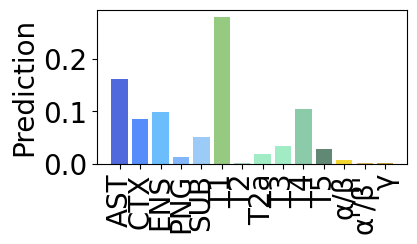

In [7]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_56"]
addition = 180
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["263_T","254_T","256_T","167_T","277_A","282_C","234_A","196_G","255_T","349_G","328_T","270_T","219_T","70_A"]

fig = plt.figure(figsize=(4,2))
ax1 = fig.add_subplot(1,1,1)
plot_celltype_prediction_bar(model_dict["DeepFlyBrain"],start_x, ax1)

plt.savefig("figures/augmentation_pruning/ISE1_Enh56_add180_mut0_prediction_bar.pdf",transparent=True)

### Plotting prediction scores of a genomic enhancer during each mutational step

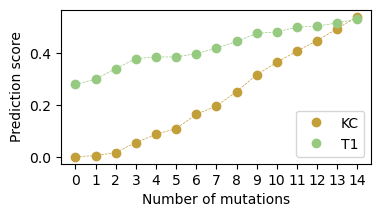

In [8]:
plt.figure(figsize=(4,2))
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_56"]
addition = 180
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["263_T","254_T","256_T","167_T","277_A","282_C","234_A","196_G","255_T","349_G","328_T","270_T","219_T","70_A"]

pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
pred = np.array(pred)  
_ = plt.plot(pred[:,34],label="KC",linestyle="",marker="o",color="#c39f3a")
_ = plt.plot(pred[:,34],linestyle="--",linewidth=0.5,color="#c39f3a")
_ = plt.plot(pred[:,22],label="T1",linestyle="",marker="o",color="#96ca80")
_ = plt.plot(pred[:,22],linestyle="--",linewidth=0.5,color="#96ca80")

_ = plt.xticks(range(15),list(range(15)))

plt.legend()
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/augmentation_pruning/ISE1_Enh56_add180_mut0_mut14_topic35_topic23_prediction.pdf",transparent=True)

### Plotting nucleotide contribution scores before and after mutations

0,1,2,3,4,5,6,7,8,9,10,11,12,13,

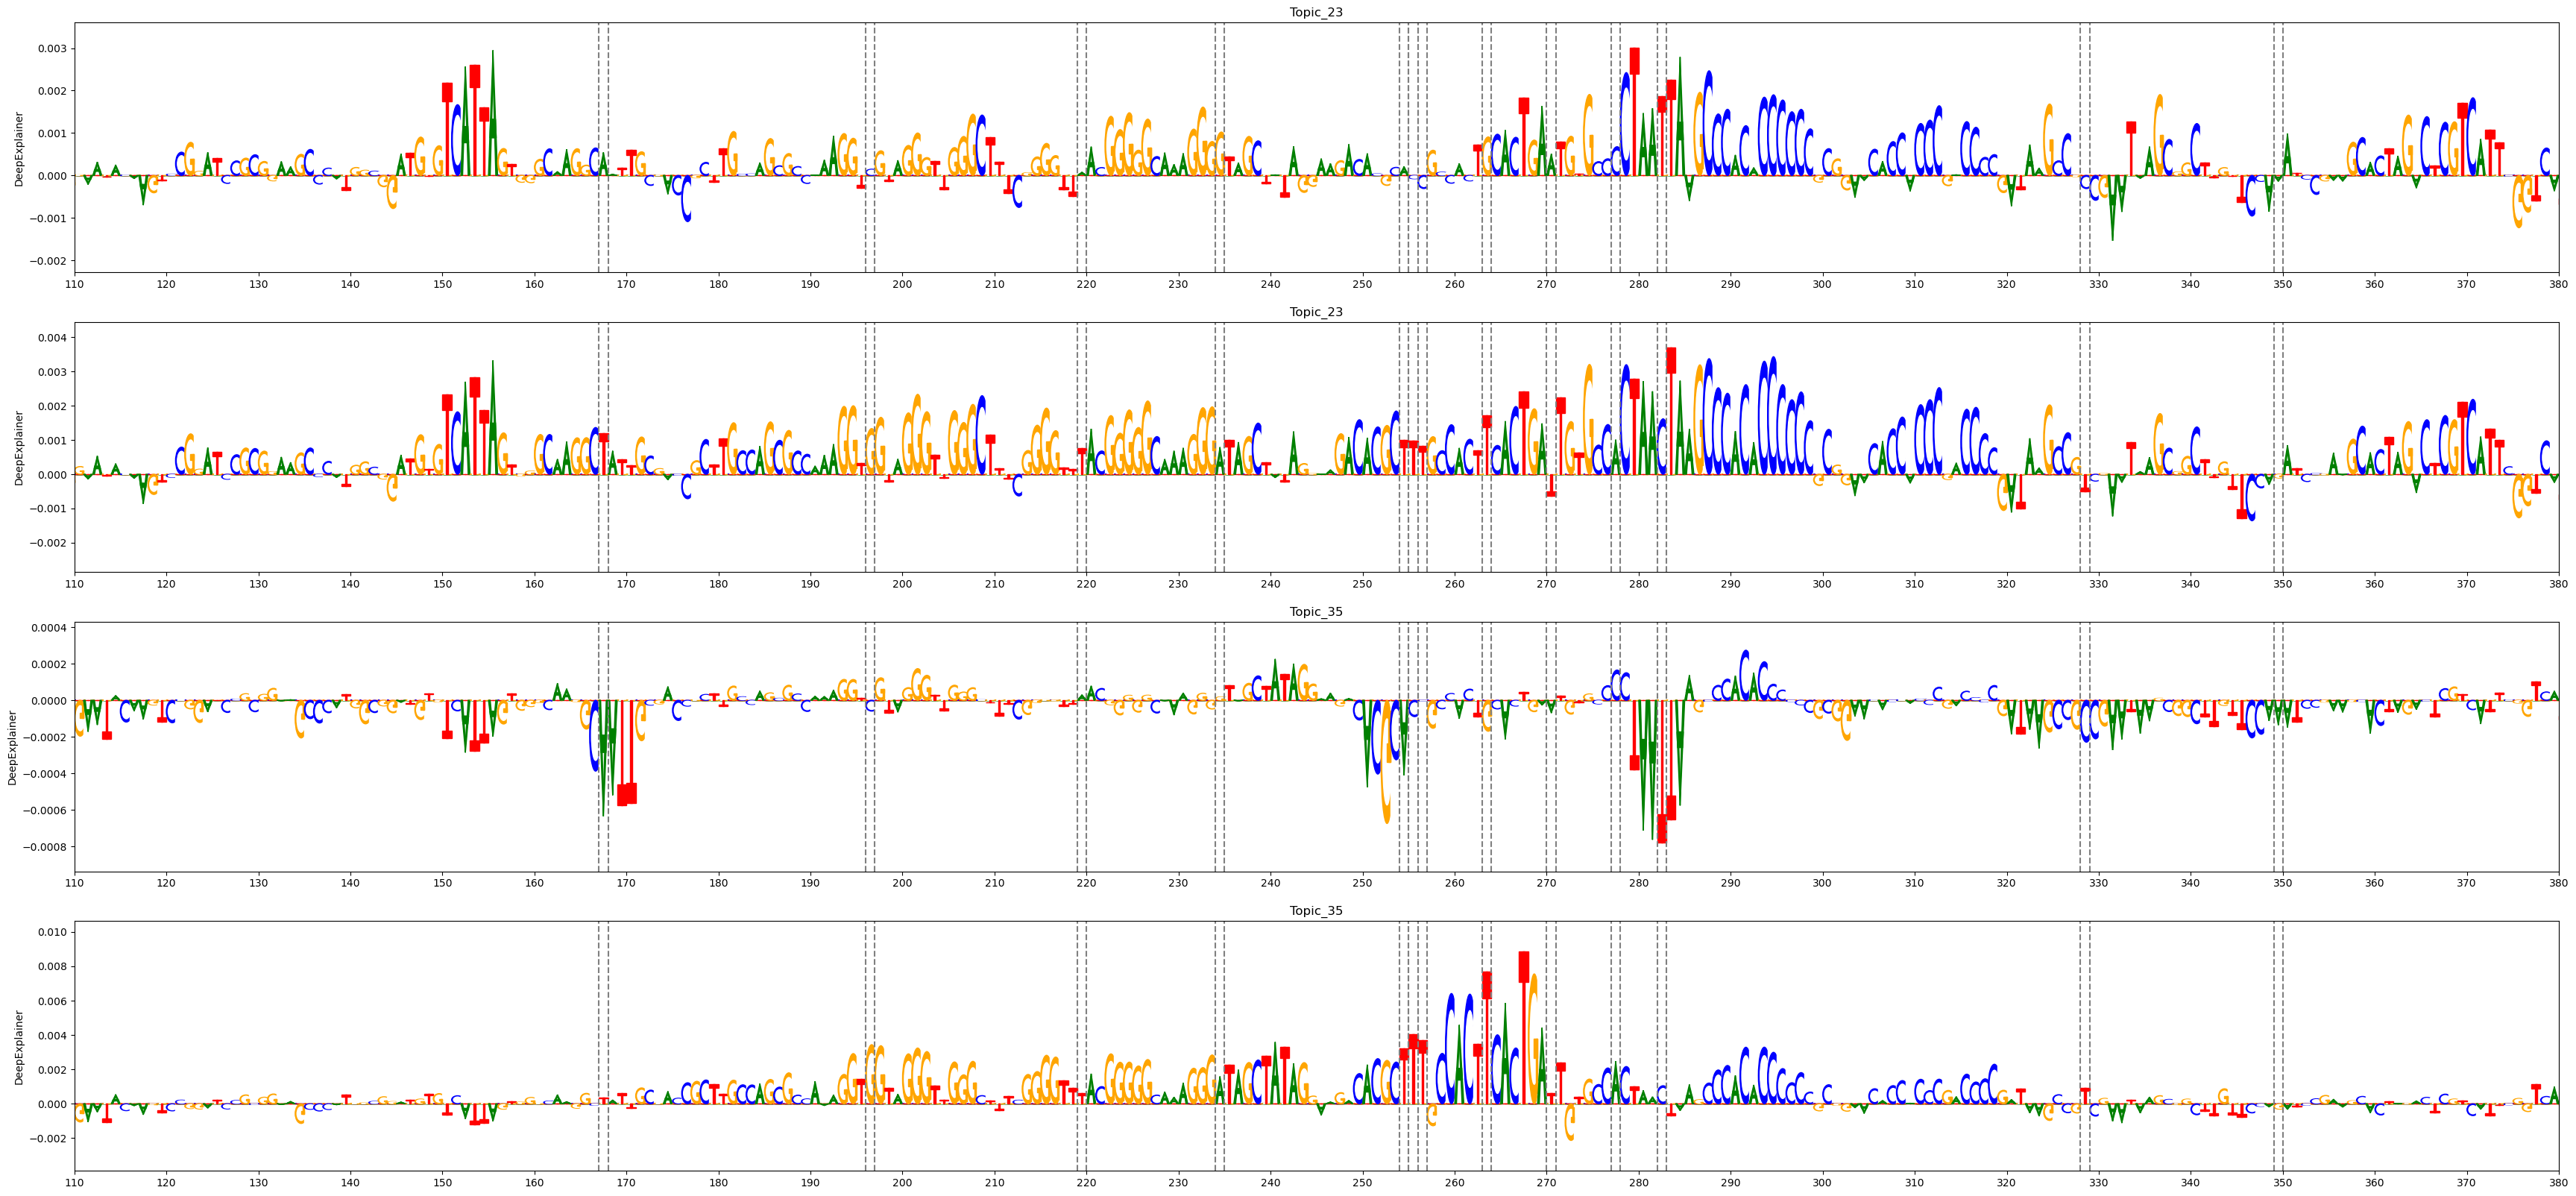

In [9]:
name = enh_name["Enh_56"]
addition = 180
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["263_T","254_T","256_T","167_T","277_A","282_C","234_A","196_G","255_T","349_G","328_T","270_T","219_T","70_A"]
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

st = 110
end = 380

ntrack = 4
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 23)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 23)
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])

plt.savefig("figures/augmentation_pruning/ISE1_Enh56_add180_st110_end380_deepexplainer_mut0_mut14_topic35_topic23.pdf",transparent=True)


### Applying mutations to a genomic enhancer to add a second enhancer code into the enhancer
### Selected mutations are shown at the bottom of this notebook

In [10]:
#ISE4
name = enh_name["Enh_28"]
addition = 120
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
for mut in ["175_T","255_G","314_A","297_T","347_C","236_A","151_T","212_G","221_G","190_C","388_T","202_G","401_T"]:
    mutloc = int(mut.split("_")[0])
    mutnuc = mut.split("_")[1]
    start_x[0][mutloc,:] = np.array(nuc_to_onehot[mutnuc], dtype='int8')
    
for nuc in start_x[:,80:80+300][0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")

GTTCTTGCGACTTAGAAGGGCTTTTCAAACAGCAACACCAGCAAACAACTAACGCCTGTTGCCGCTGGCCATGTCCTGACTTAACGCTTTGTGCATGGATTTGGCTCACACCCCGACAACGAGGACAAGCGGGTCAAAAGGGTGGTGCTGATGGTCAAGGGGGATGGCTCAATGAGAGGTGAGTTGTTGGCTTTTAAAGTTGGTACACACAAACCAGTCAGGCAAGCACACCATACATGCTCAAAGGCTTTCGGCCCGGTCGTTGGTCAACTTTTAATAATCGCAAAGACGAGTCGCTTT

### Plotting prediction scores of a genomic enhancer before the mutationsv

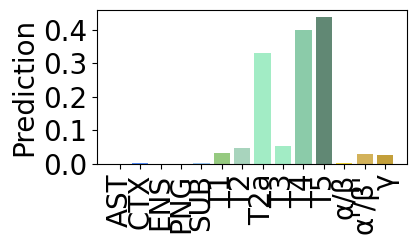

In [11]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_28"]
addition = 120
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["175_T","255_G","314_A","297_T","347_C","236_A","151_T","212_G","221_G","190_C","388_T","202_G","401_T"]

fig = plt.figure(figsize=(4,2))
ax1 = fig.add_subplot(1,1,1)
plot_celltype_prediction_bar(model_dict["DeepFlyBrain"],start_x, ax1)

plt.savefig("figures/augmentation_pruning/ISE4_Enh28_add120_mut0_prediction_bar.pdf",transparent=True)

### Plotting prediction scores of a genomic enhancer during each mutational step

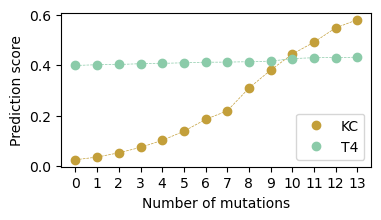

In [12]:
plt.figure(figsize=(4,2))
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_28"]
addition = 120
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["175_T","255_G","314_A","297_T","347_C","236_A","151_T","212_G","221_G","190_C","388_T","202_G","401_T"]

pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
pred = np.array(pred)  
_ = plt.plot(pred[:,34],label="KC",linestyle="",marker="o",color="#c39f3a")
_ = plt.plot(pred[:,34],linestyle="--",linewidth=0.5,color="#c39f3a")
_ = plt.plot(pred[:,1],label="T4",linestyle="",marker="o",color="#8bcba9")
_ = plt.plot(pred[:,1],linestyle="--",linewidth=0.5,color="#8bcba9")

_ = plt.xticks(range(14),list(range(14)))

plt.legend()
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/augmentation_pruning/ISE4_Enh28_add120_mut0_mut13_topic35_topic2_prediction.pdf",transparent=True)

### Plotting nucleotide contribution scores before and after mutations

0,1,2,3,4,5,6,7,8,9,10,11,12,

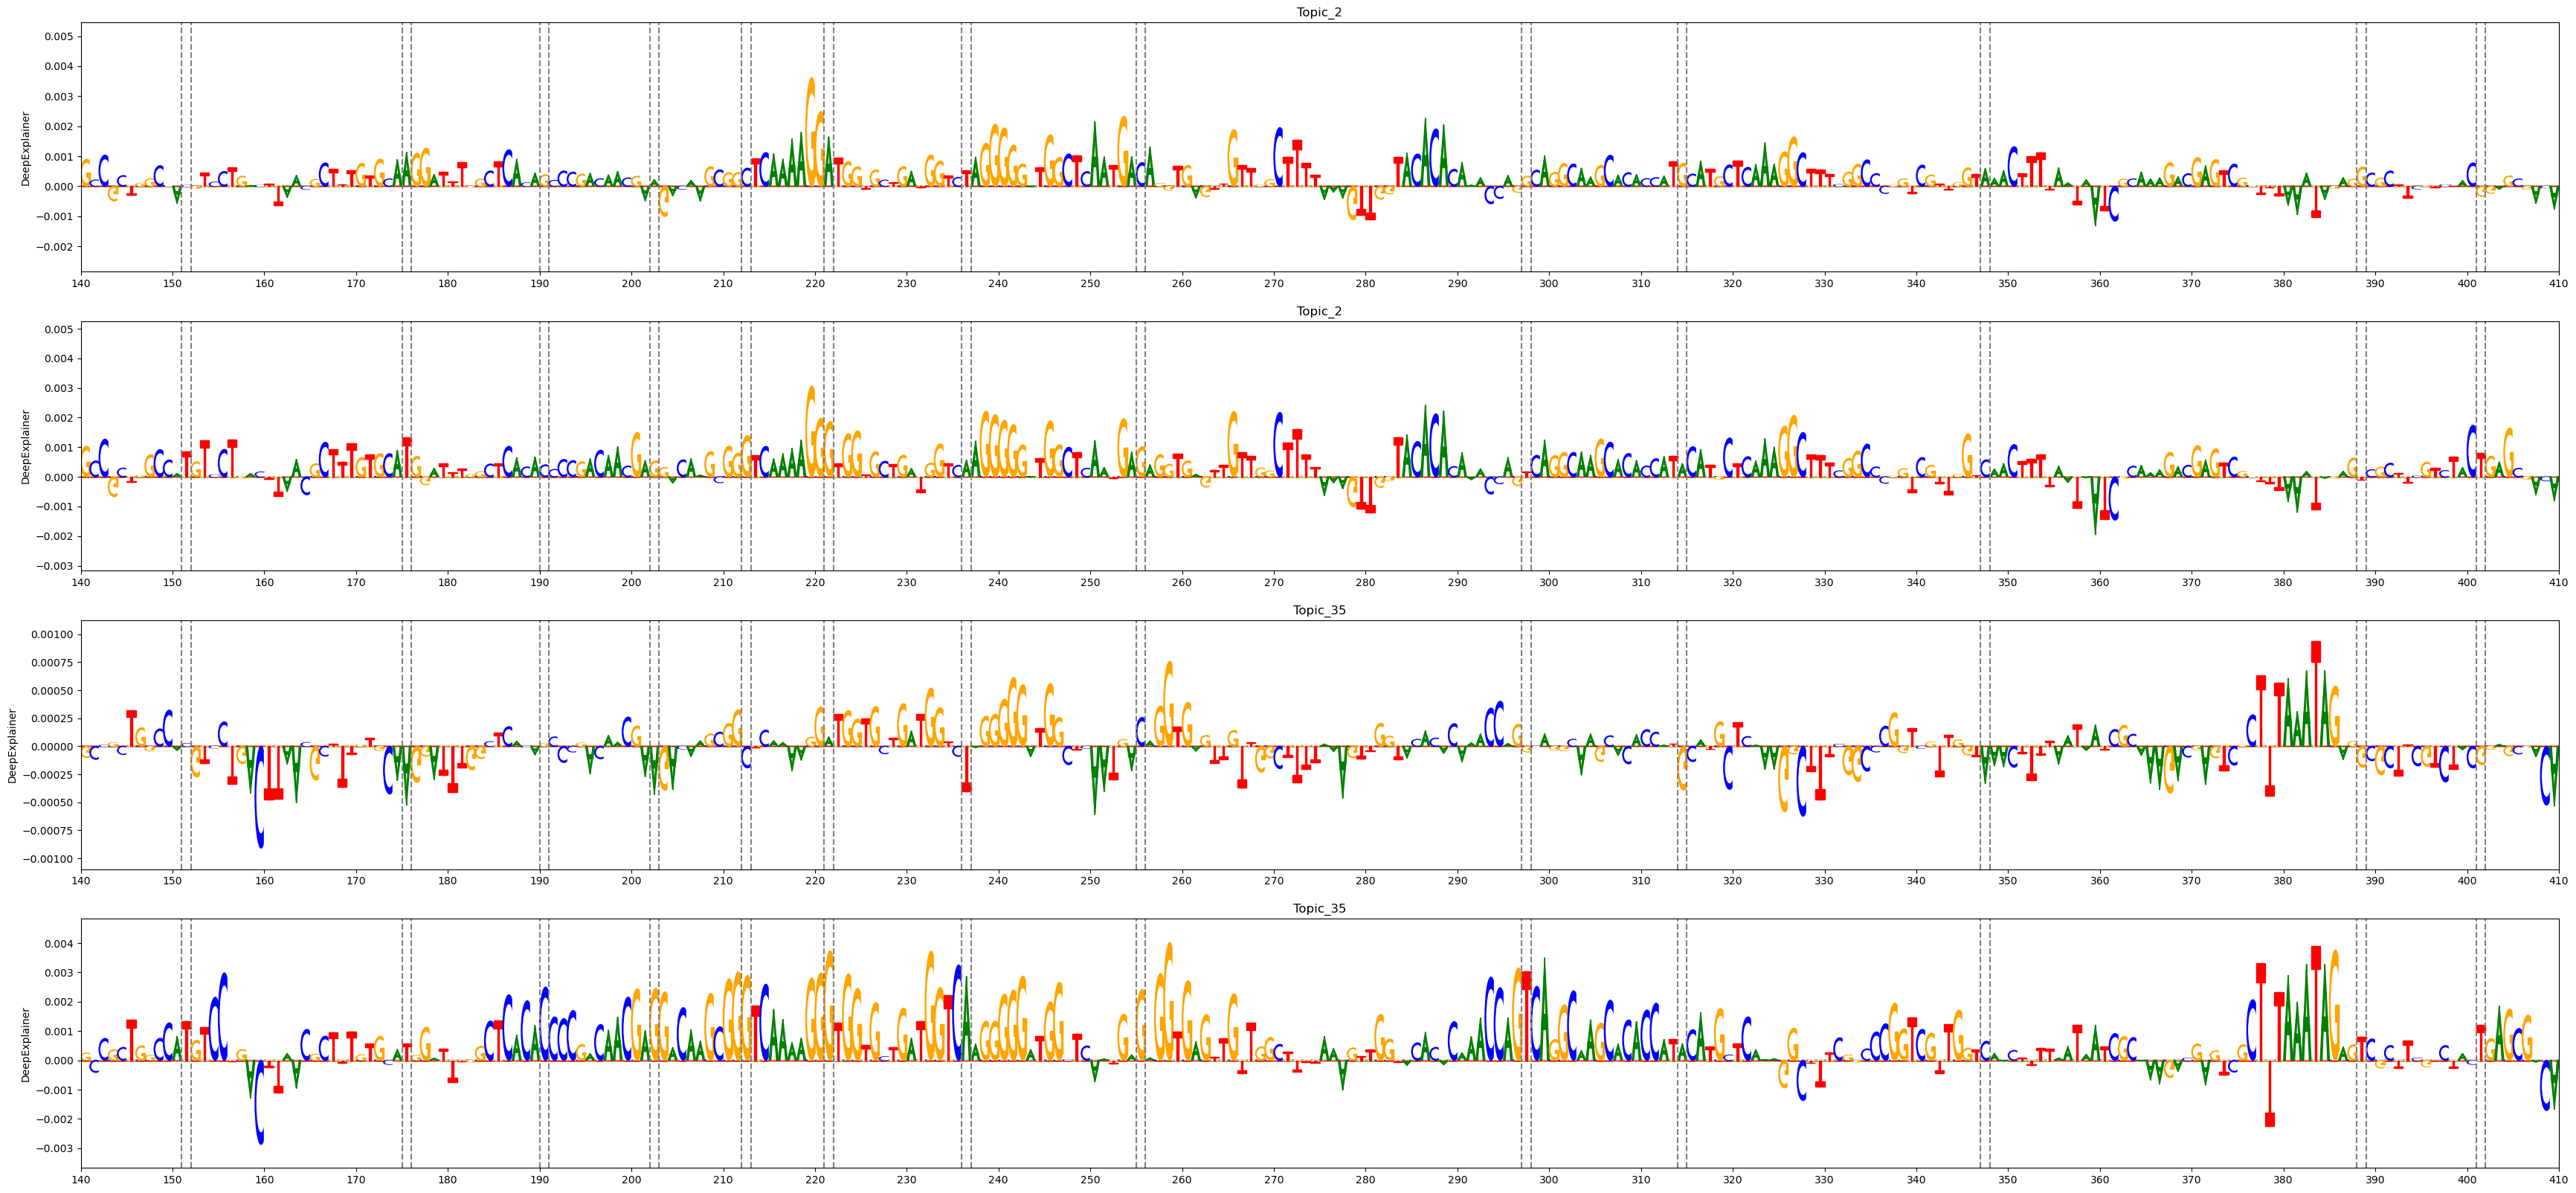

In [13]:
name = enh_name["Enh_28"]
addition = 120
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["175_T","255_G","314_A","297_T","347_C","236_A","151_T","212_G","221_G","190_C","388_T","202_G","401_T"]
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

st = 140
end = 410

ntrack = 4
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 2)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 2)
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])

plt.savefig("figures/augmentation_pruning/ISE4_Enh28_add120_st140_end410_deepexplainer_mut0_mut13_topic35_topic2.pdf",transparent=True)


### Loading the peak file from Janssens et al.

In [14]:
print('Loading data...')
f = open('data/augmentation_pruning/Janssens_et_al_DFB_peaks_predictions.pkl', "rb")
Janssens_et_al_DFB_peaks_predictions = pickle.load(f)
f.close()

Loading data...


### Plotting the number of sequences that score high for multiple cell types

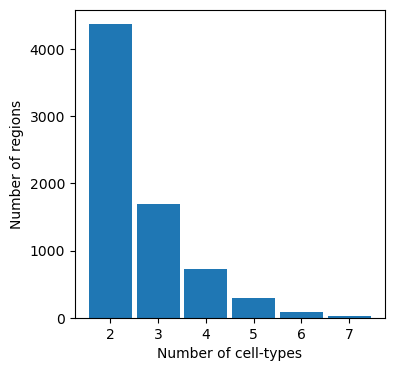

In [15]:
plt.figure(figsize=(4,4))

plt.hist(np.sum(Janssens_et_al_DFB_peaks_predictions["predictions"][:,[67,24,55,33,35,22,19,43,9,1,31,20,76,34]]>0.3,axis=1),bins=6,range=(1.5,7.5),rwidth=0.9)

plt.xlabel("Number of cell-types")
plt.ylabel("Number of regions")
plt.savefig("figures/augmentation_pruning/multiple_celltypes_barplot_th03.pdf",transparent=True)


### Plotting the gamma Kenyon Cell versus T1 prediction score with highlighting one of the region that scores high for both cell types

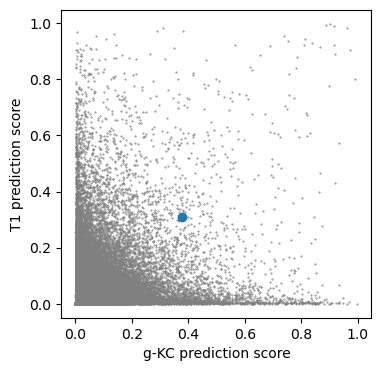

In [16]:
plt.figure(figsize=(4,4))

plt.scatter(Janssens_et_al_DFB_peaks_predictions["predictions"][:,34],Janssens_et_al_DFB_peaks_predictions["predictions"][:,22],s=0.2,color="gray")
plt.scatter(Janssens_et_al_DFB_peaks_predictions["predictions"][:,34][Janssens_et_al_DFB_peaks_predictions["ids"]=='unk_12_peak_427::chr2R:16905967-16906467'],
           Janssens_et_al_DFB_peaks_predictions["predictions"][:,22][Janssens_et_al_DFB_peaks_predictions["ids"]=='unk_12_peak_427::chr2R:16905967-16906467'],marker="o")

plt.xlabel("g-KC prediction score")
plt.ylabel("T1 prediction score")
plt.savefig("figures/augmentation_pruning/scatter_T1_vs_gKC.png",transparent=True,dpi=300)


### Applying mutations to a genomic enhancer to remove the second enhancer code from the genomic enhancer
### Selected mutations are shown at the bottom of this notebook
### Plotting prediction scores of a genomic enhancer before the mutations

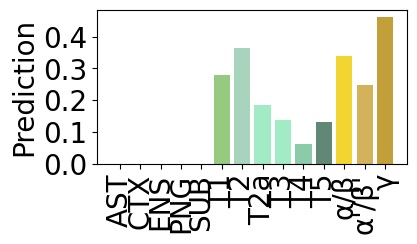

In [17]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["324_G","176_A","335_T","93_T","350_C","323_T","363_A"]

fig = plt.figure(figsize=(4,2))
ax1 = fig.add_subplot(1,1,1)
plot_celltype_prediction_bar(model_dict["DeepFlyBrain"],start_x, ax1)

plt.savefig("figures/augmentation_pruning/ISE5_Enh41_KCKD_add378_mut0_prediction_bar.pdf",transparent=True)

In [18]:
name = enh_name["Enh_41"]
for nuc in cloned_enhancers_dict_raw["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][0,:178]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")
for nuc in cloned_enhancers_dict_raw["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][0,500+178:]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")

ATCTGAAGATATCATCCTTTATTTAATTGATTTTATGCTTTTCCTGGAGCAGGAACACTTAAAAGAGTATGATTGTCGGATAAACCGATGTAGAATATGTTAGTACATGTACATGATAAGAGGATAAAGTCTCAACTAGGGTATGCGATATCTGGGCAATGAGTTATCCGGAAAGTAA
TCTCTGCTTCTTCTACGTTATGGCATGCATCAAAGCGAATTCCTTCGCCGCCCATCTTTCCATTCCATTTTGATTTCCAGAGCACAAGGATTCCGGGTTATTAGGGCTTGGAAAAACAAT

In [19]:
#ISE6 T1 KD
name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])

for mut in ["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]:
    mutloc = int(mut.split("_")[0])
    mutnuc = mut.split("_")[1]
    start_x[0][mutloc,:] = np.array(nuc_to_onehot[mutnuc], dtype='int8')

for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")

AGTAGACCTGCGAATGCCGAGCTCGTGCTCCAATTAATAAGCGATGGAGCGAGGTCCTGGCGGCGAATGGGGCTTTTACGGCACAGTCCGTTGCCTCGCGTCGTAAACTCCGATGATAATGAAAATAAAAATAAAGATGGGGATAAAACTGTTGCGCGCCAACGCAGCCTTTTGTCCAATGAAATAGACAAAGTAAGTCGCTTAATTCGGTCGCTTCCTCTACTTTCACCCAGTCTCGACTCCCTGCCACCCTTTCCCCCACTGAAGGGTCCTTTCCCTTTTCCCTGCCGCTTTGGCTTTTACTTTCTCTGCCGGTCGTTGCGCTCGATCCGCTTCAGTGCAATTCAATAGCGCAGTATGCGCGTGCCCGTGACTGTCTTTGTGTGTGTGTGTATGTGTGTGTGTCAGTCCTGGTGTCCTGTTCTGCGCACCAGTGTGTGTCCTGAGTGTGTCCTTCTGATTGTCTTCCACCTAACGGTTAAAGTGTGATGCTCCGCTTC

### Plotting prediction scores of a genomic enhancer during each mutational step

0,1,2,3,4,5,6,7,8,

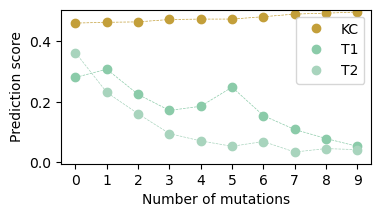

In [20]:
plt.figure(figsize=(4,2))
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]

pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0])
pred = np.array(pred)  
_ = plt.plot(pred[:,34],label="KC",linestyle="",marker="o",color="#c39f3a")
_ = plt.plot(pred[:,34],linestyle="--",linewidth=0.5,color="#c39f3a")
_ = plt.plot(pred[:,22],label="T1",linestyle="",marker="o",color="#8bcba9")
_ = plt.plot(pred[:,22],linestyle="--",linewidth=0.5,color="#8bcba9")
_ = plt.plot(pred[:,19],label="T2",linestyle="",marker="o",color="#a8d4bd")
_ = plt.plot(pred[:,19],linestyle="--",linewidth=0.5,color="#a8d4bd")

_ = plt.xticks(range(10),list(range(10)))

plt.legend()
plt.ylim(-0.005,0.505)
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/augmentation_pruning/ISE6_Enh41_T1KD_add378_mut0_mut9_topic35_topic23_topic20_prediction.pdf",transparent=True)


### Plotting nucleotide contribution scores before and after mutations

0,1,2,3,4,5,6,7,8,

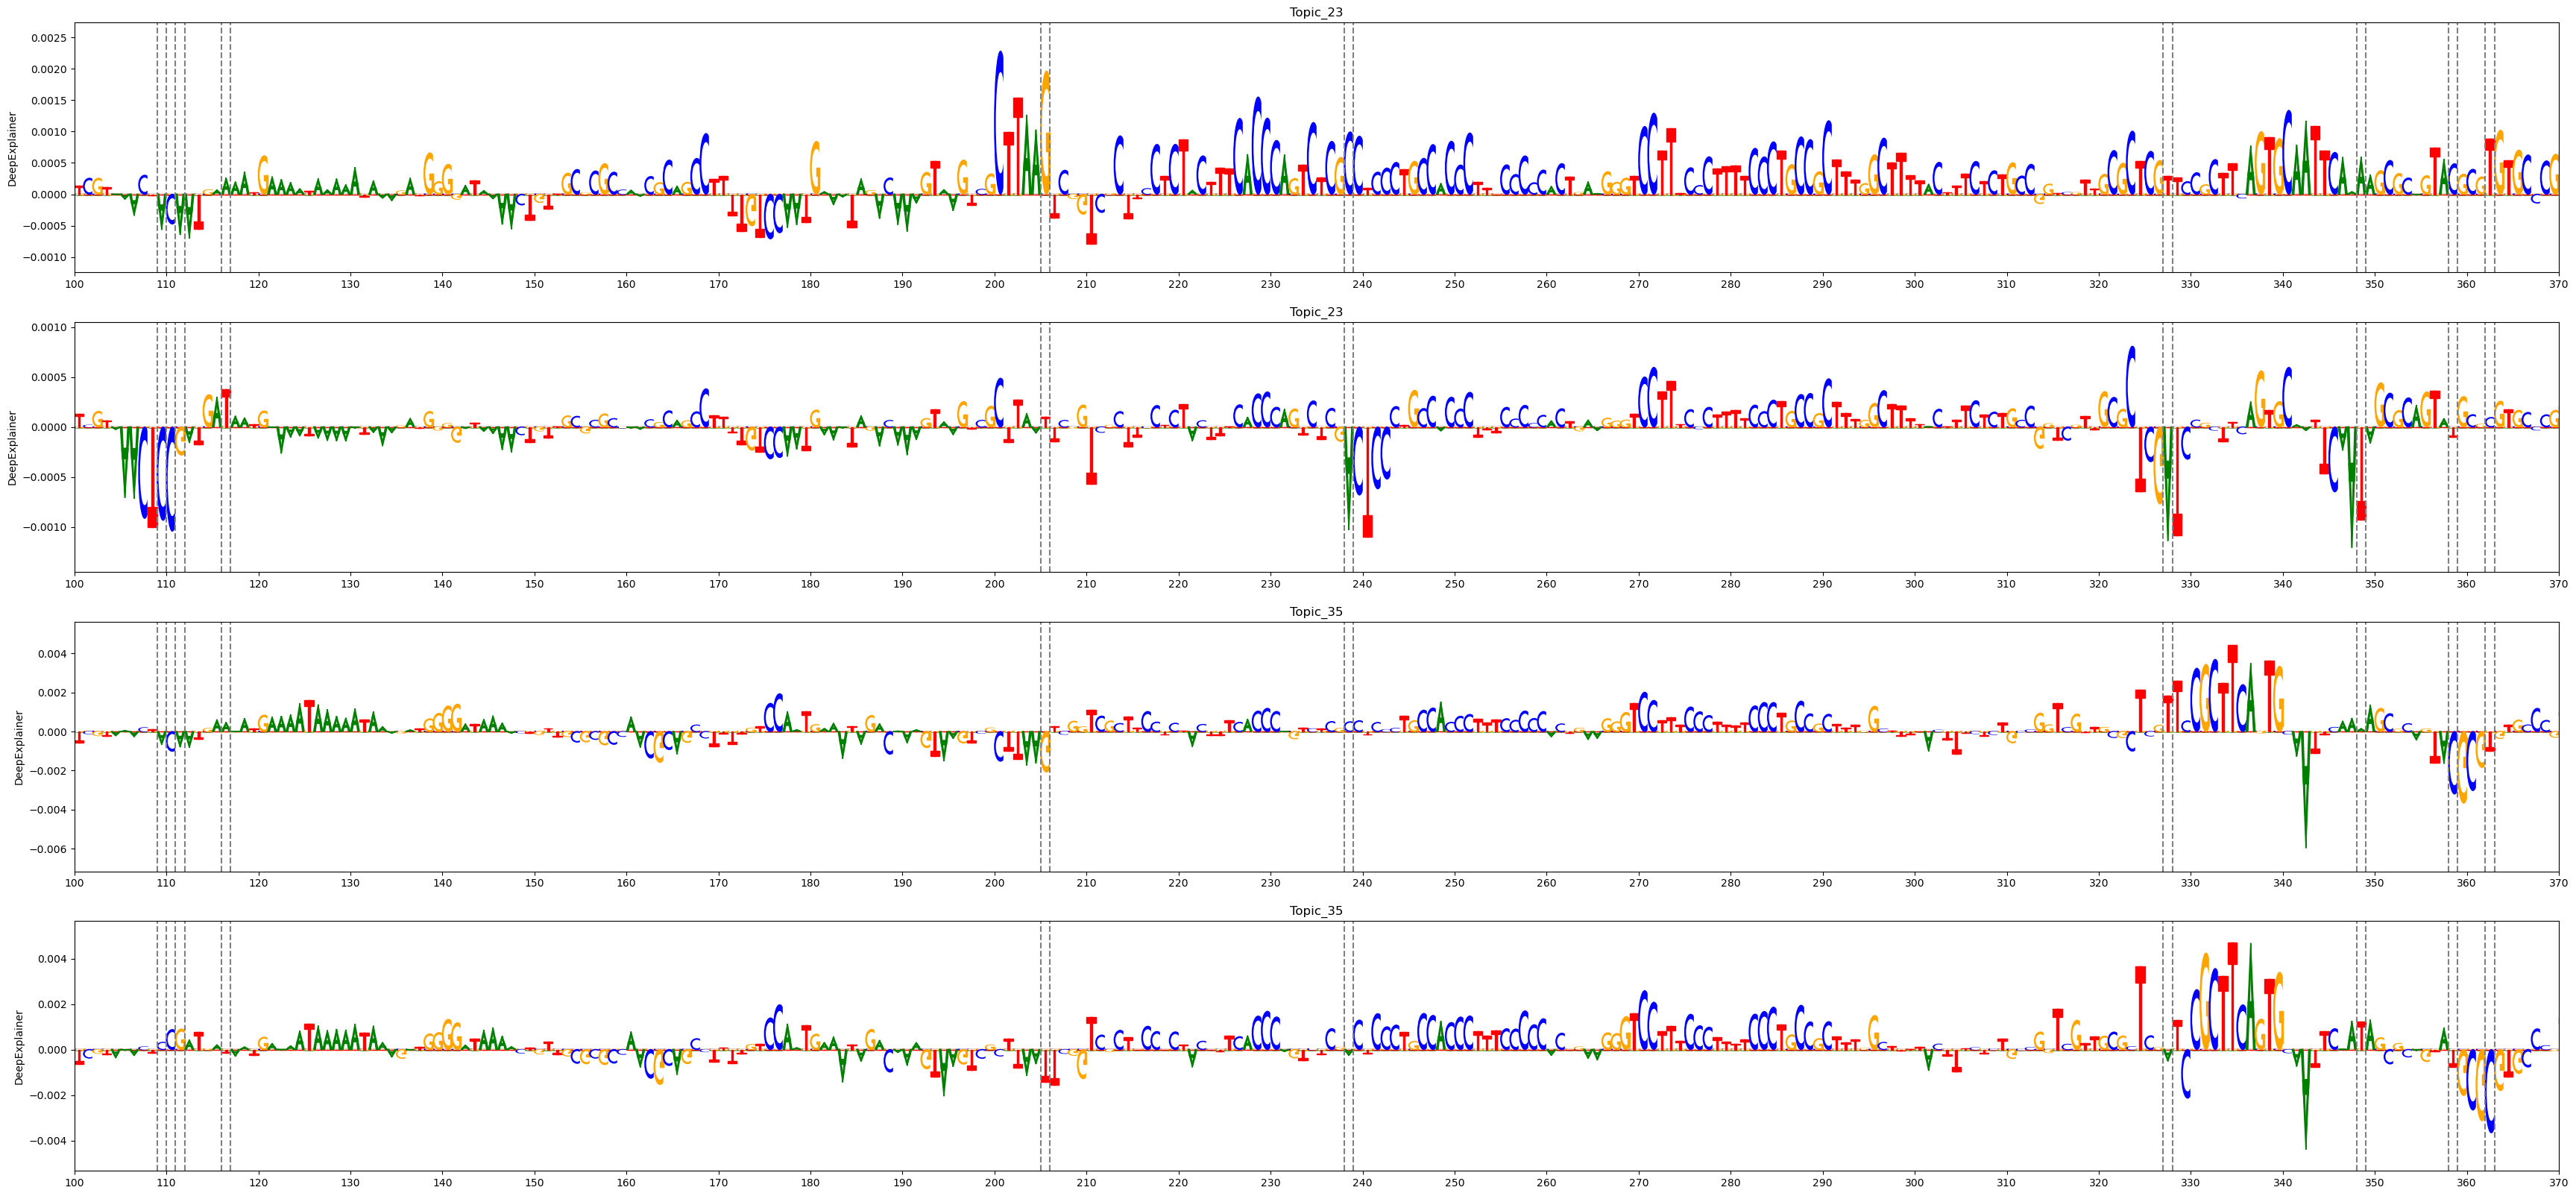

In [21]:
name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

st = 100
end = 370

ntrack = 4
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 23)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 23)
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])

plt.savefig("figures/augmentation_pruning/ISE6_Enh41_T1KD_add378_st100_end370_deepexplainer_mut0_mut9_topic35_topic23.pdf",transparent=True)


0,1,2,3,4,5,6,7,8,

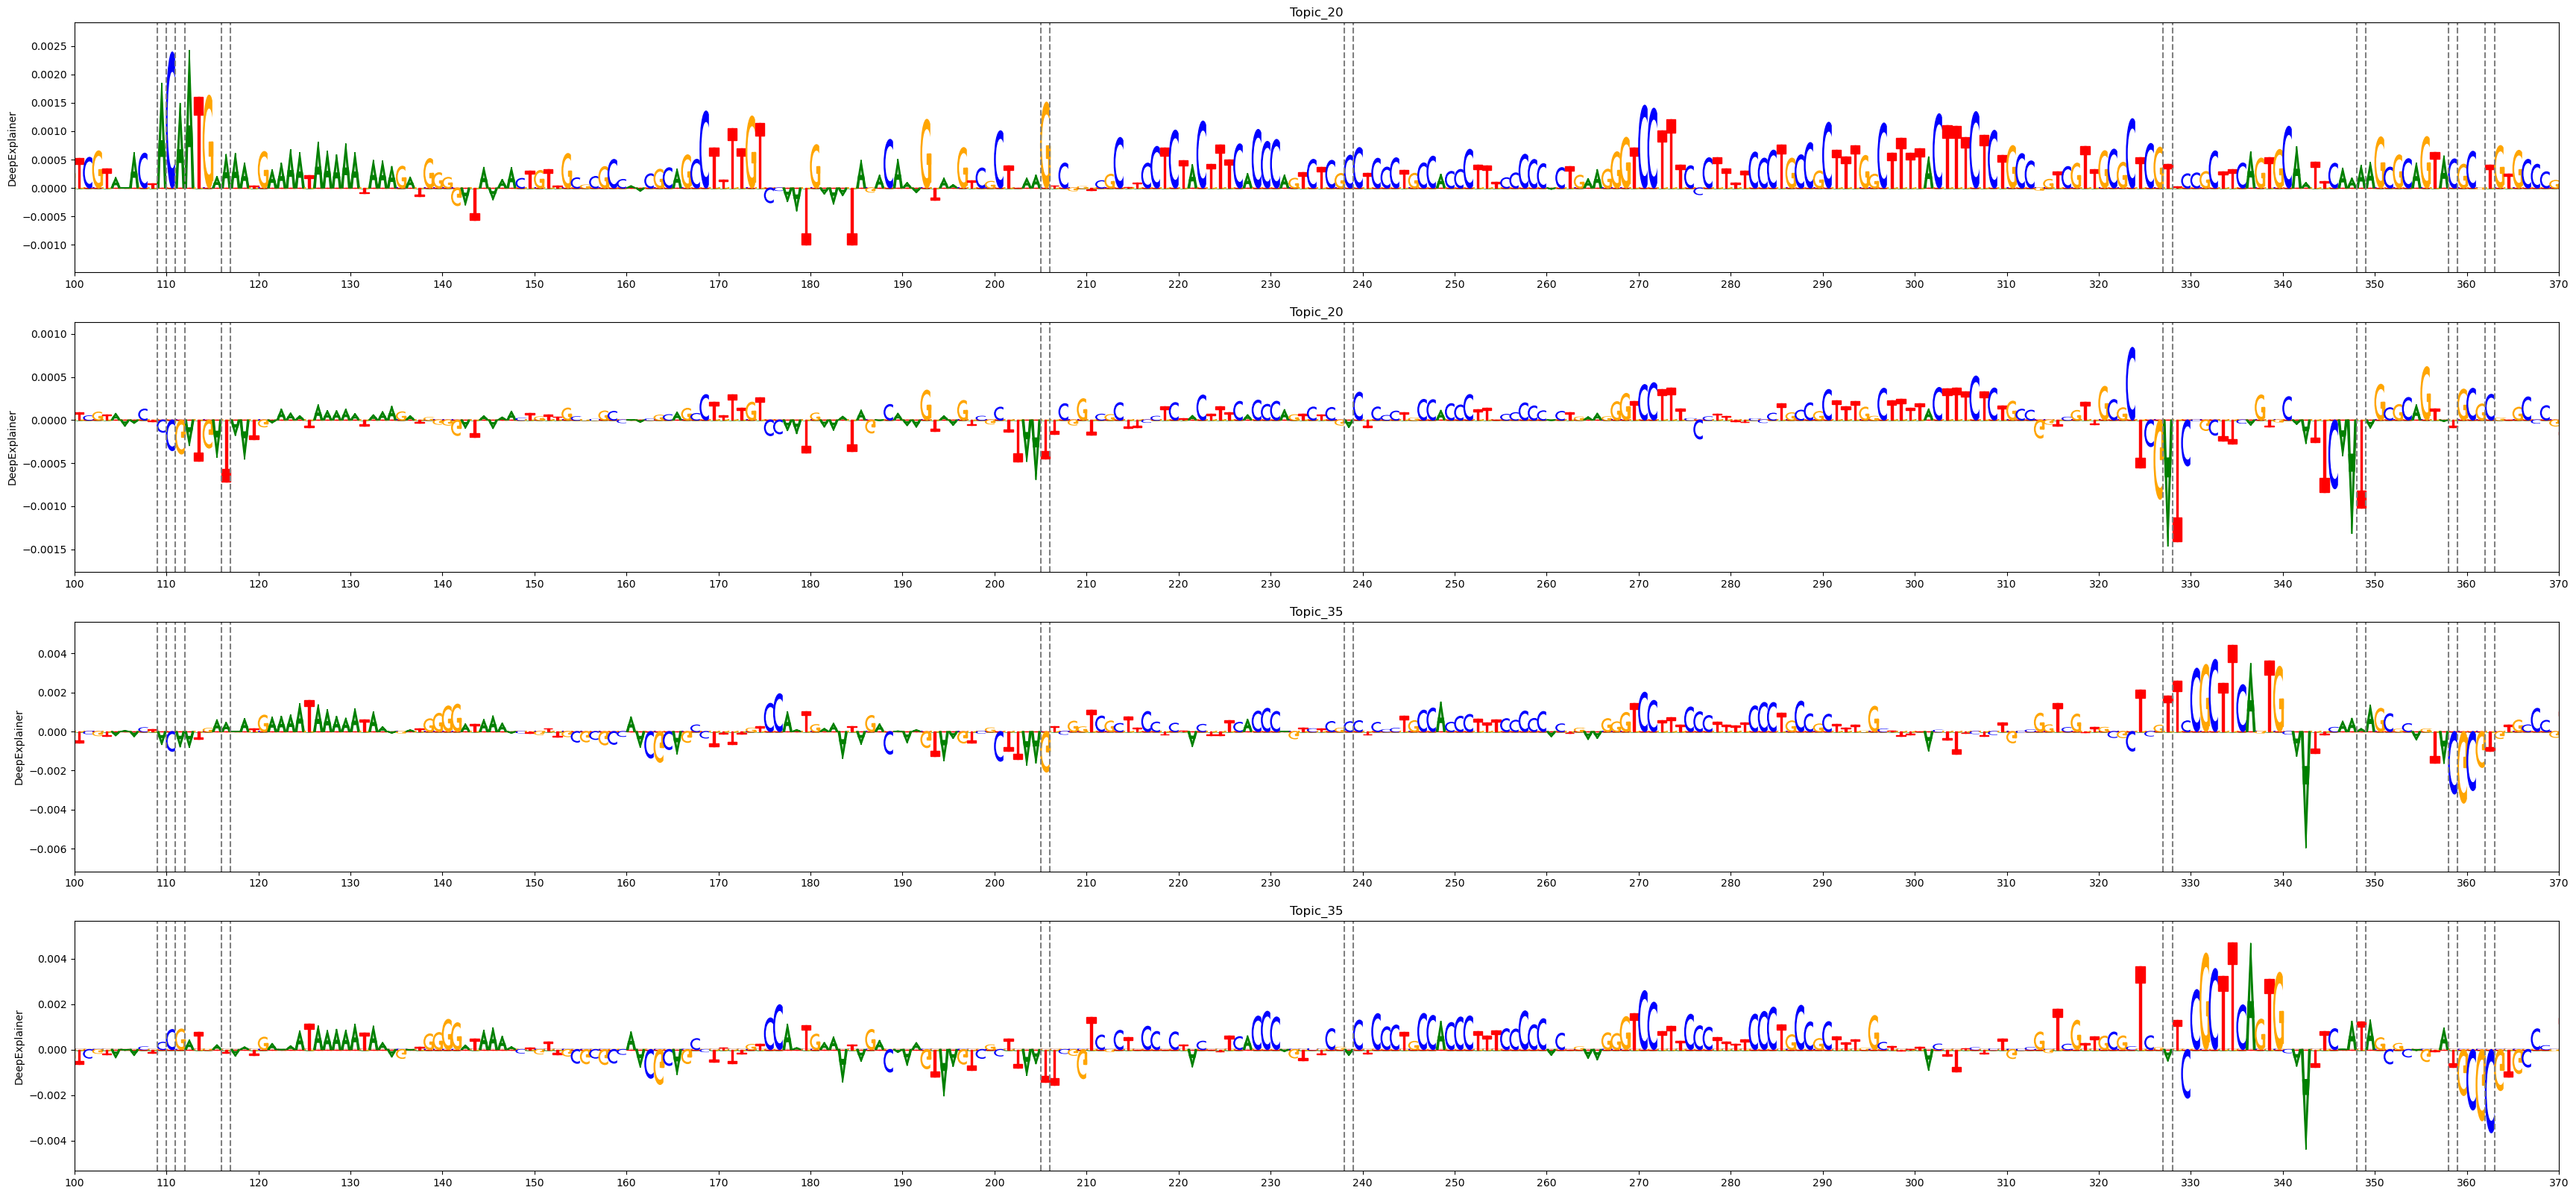

In [22]:
name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

st = 100
end = 370

ntrack = 4
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 20)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 20)
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])

plt.savefig("figures/augmentation_pruning/ISE6_Enh41_T1KD_add378_st100_end370_deepexplainer_mut0_mut9_topic35_topic20.pdf",transparent=True)


0,1,2,3,4,5,6,7,8,

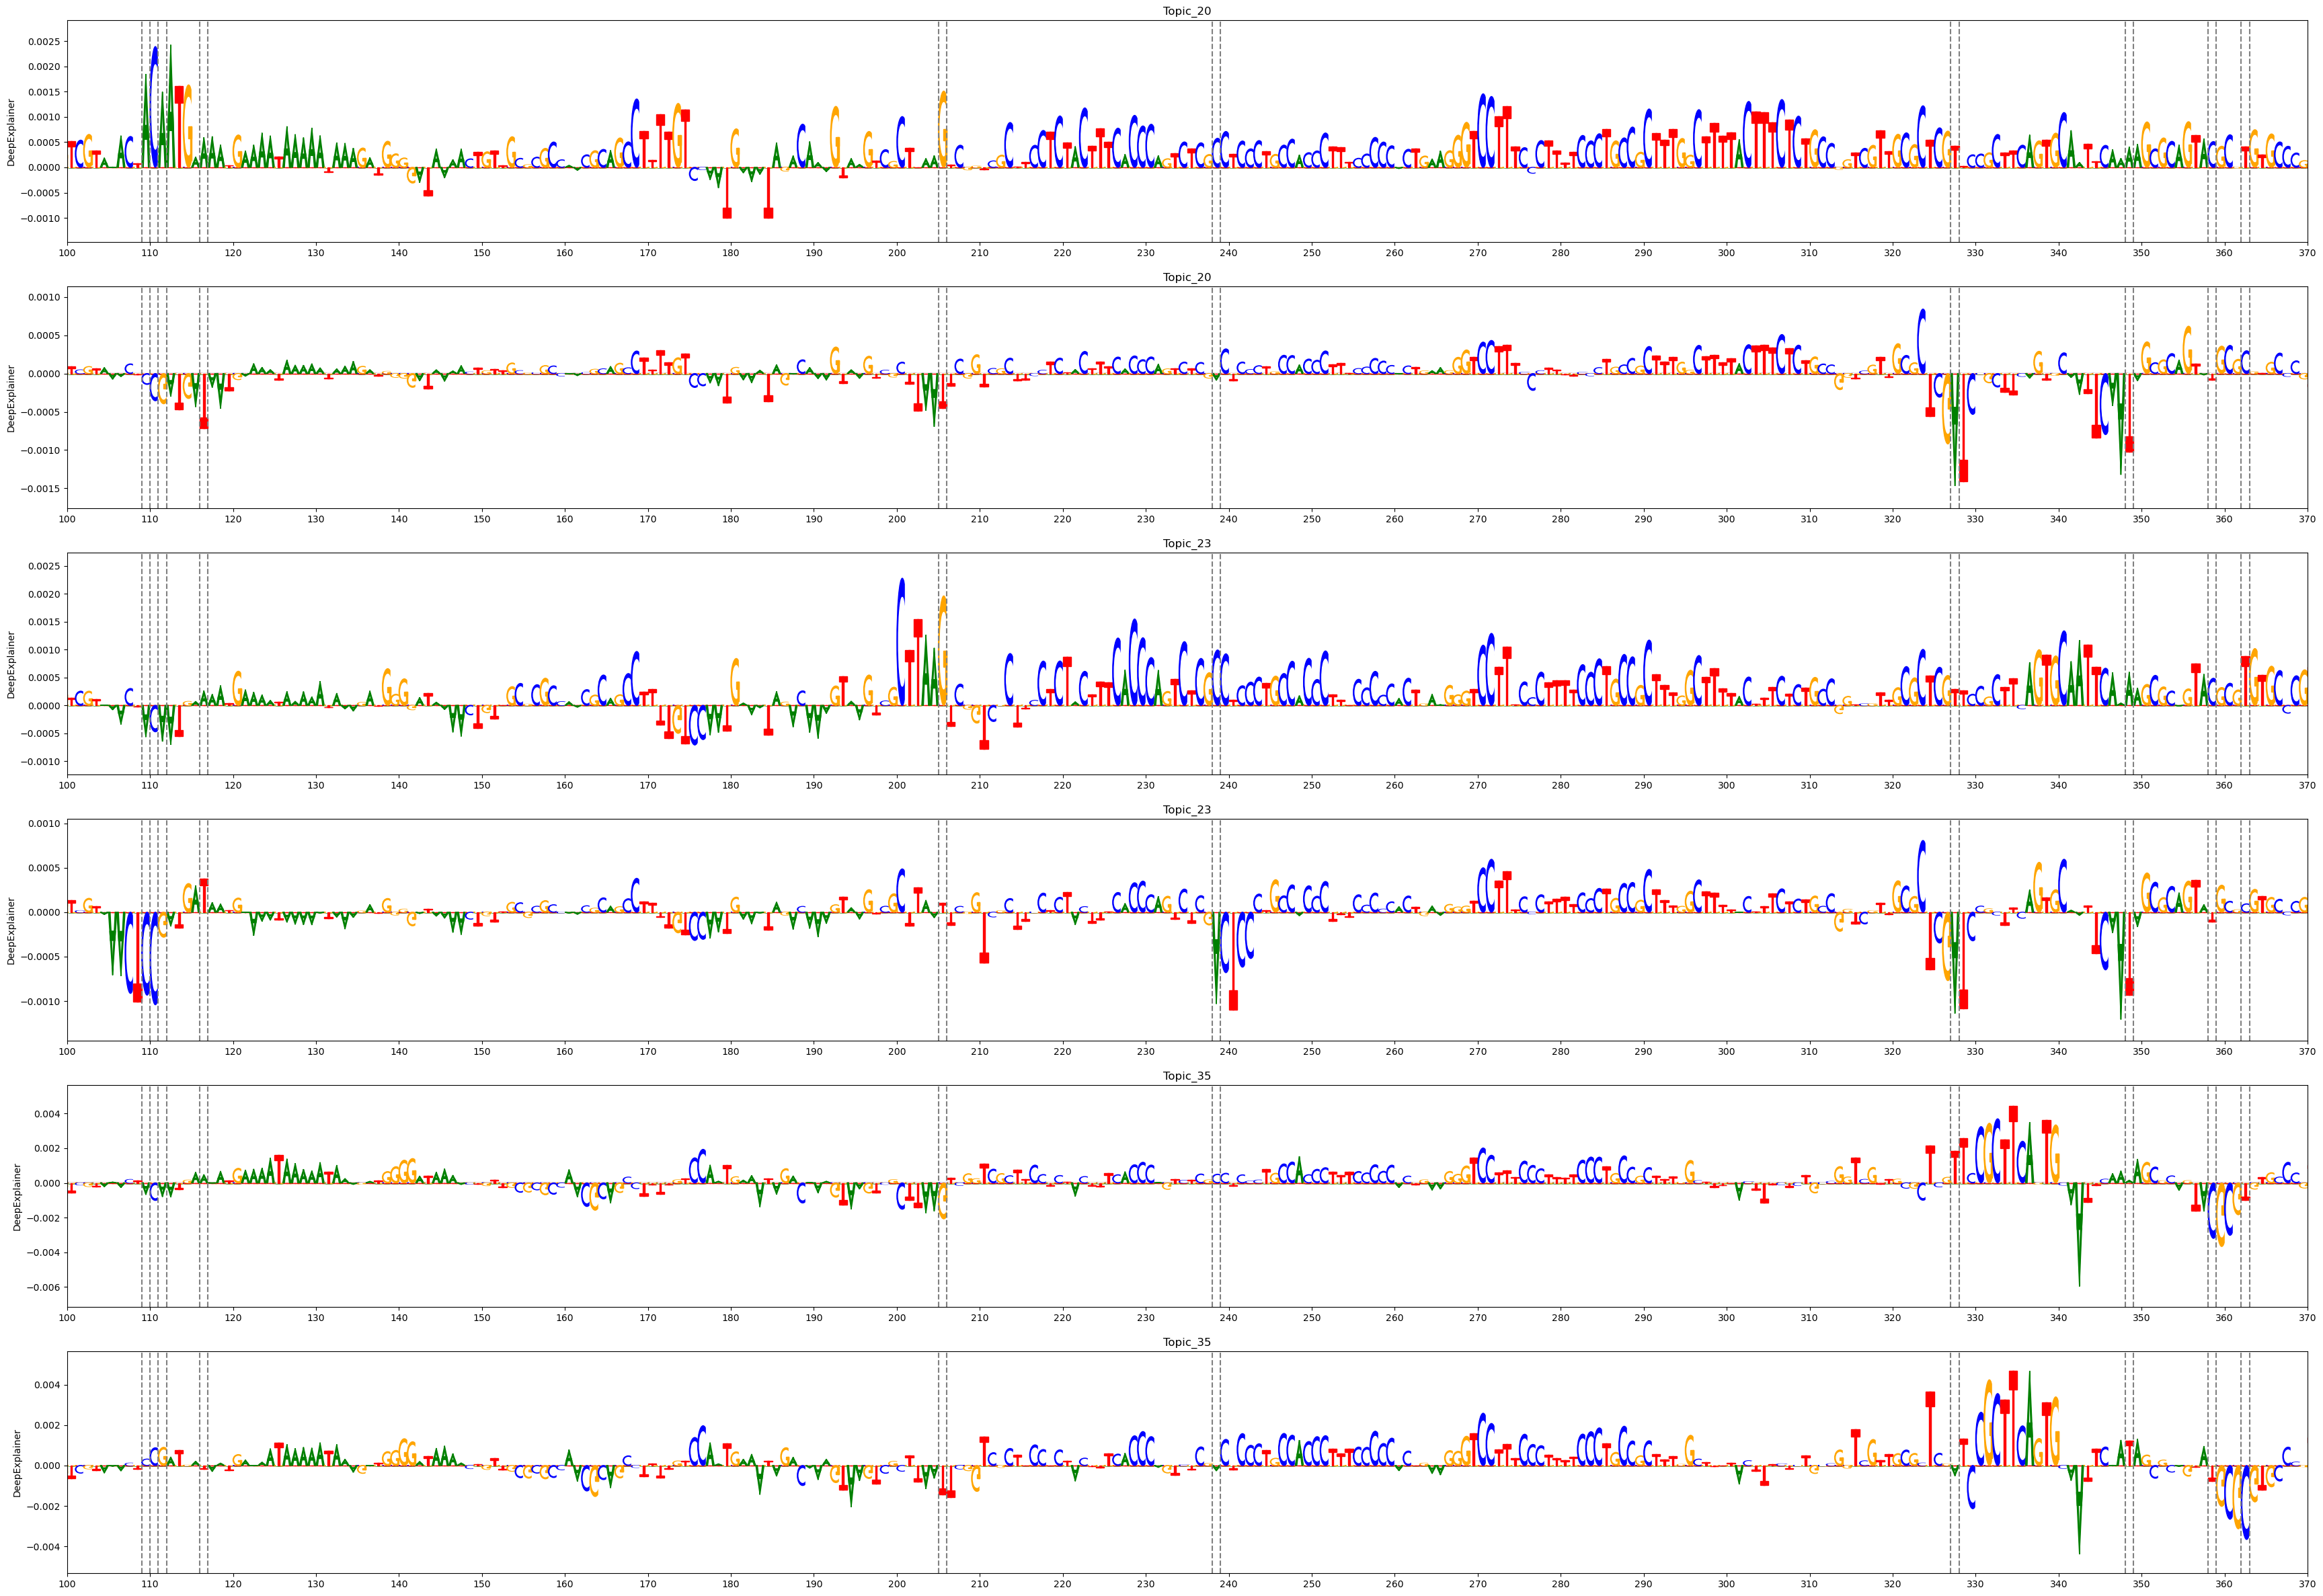

In [23]:
name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])
muts = ["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

st = 100
end = 370

ntrack = 6
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 20)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 23)
ax5 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=5, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 20)
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 23)
ax6 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=6, seq_onehot=start_x, class_no = 35)


for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax5.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax5.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax6.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax6.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])
ax5.set_xlim([st,end])
ax6.set_xlim([st,end])

plt.savefig("figures/augmentation_pruning/ISE6_Enh41_T1KD_add378_st100_end370_deepexplainer_mut0_mut9_topic35_topic23_topic20.pdf",transparent=True)


### Scatter plots showing in silico saturation mutagenesis prediction scores for each mutational steps comparing two different cell types
### The selected mutation at each step is highlighted with and orange ball

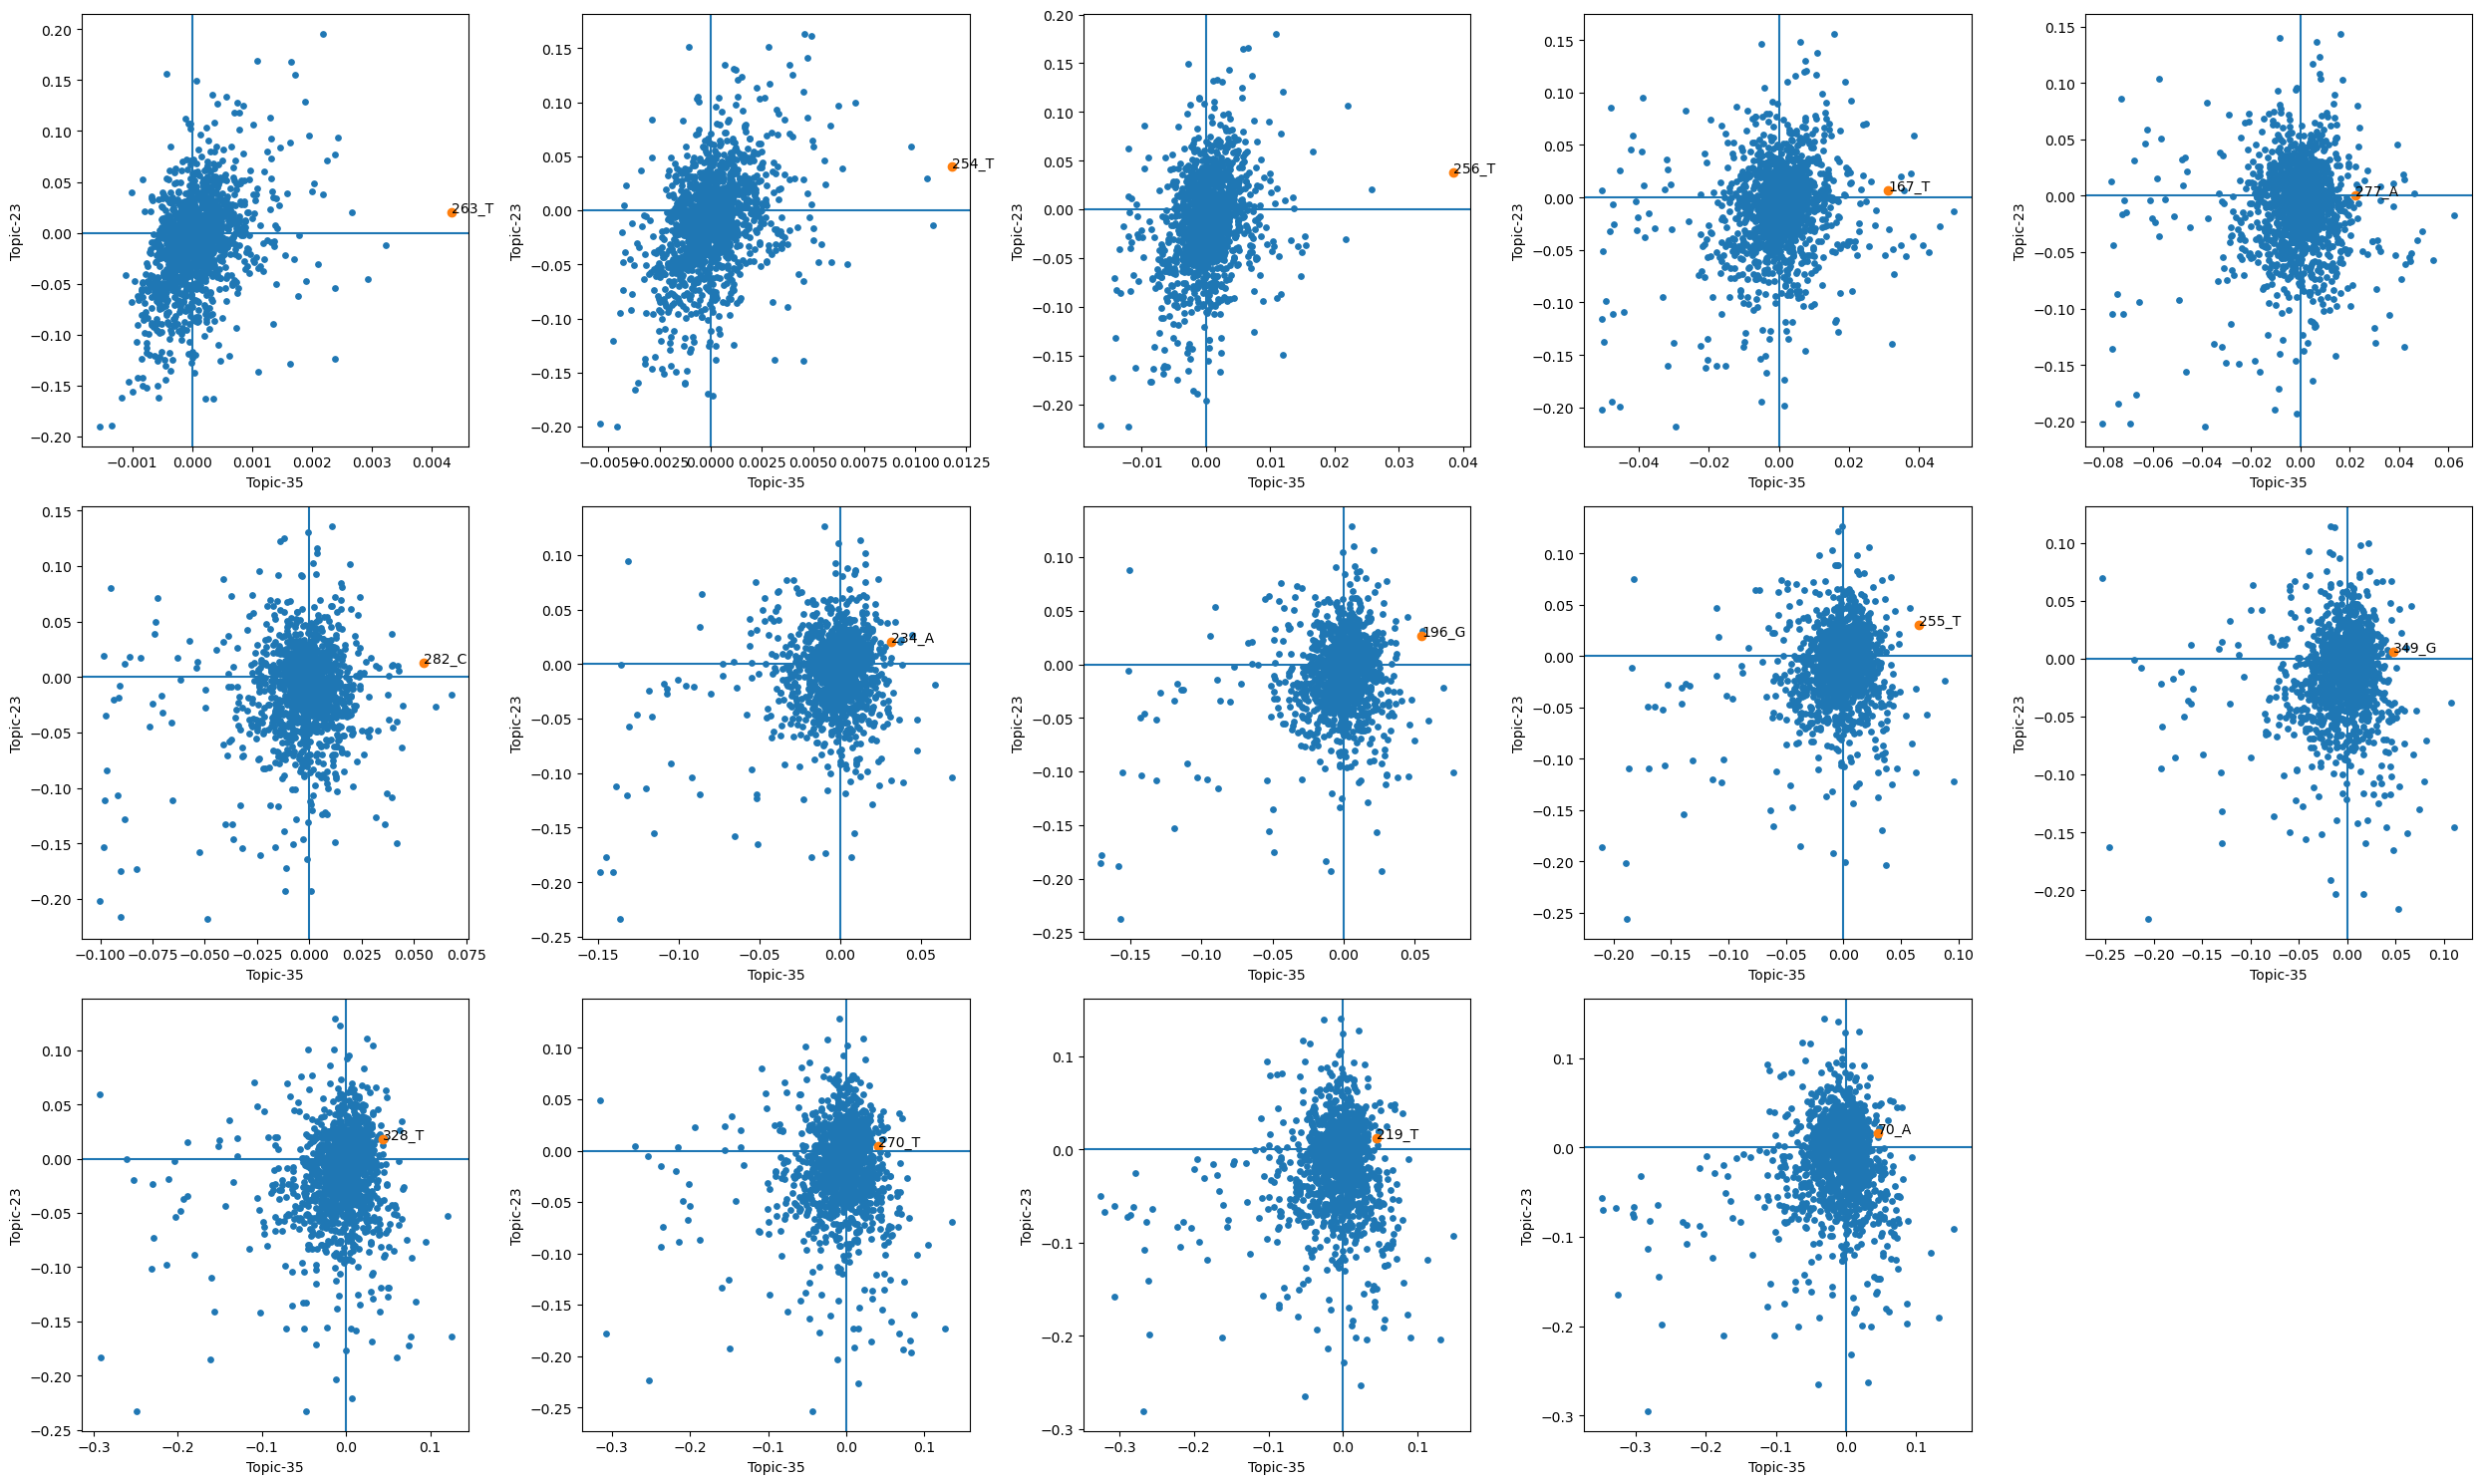

In [24]:
name = enh_name["Enh_56"]
addition = 180
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])


fig = plt.figure(figsize=(25,15))

for i,next_one in enumerate(["263_T","254_T","256_T","167_T","277_A","282_C","234_A","196_G","255_T","349_G","328_T","270_T","219_T","70_A"]):

    ax =  fig.add_subplot(3,5,i+1)
    
    mutagenesis_X = utils.create_saturation_mutagenesis_x(start_x)
    prediction_mutagenesis_X = model_dict["DeepFlyBrain"].predict(mutagenesis_X["X"])
    original_prediction = model_dict["DeepFlyBrain"].predict(start_x)
    
    plt.scatter(prediction_mutagenesis_X[:,34]-original_prediction[:,34],prediction_mutagenesis_X[:,22]-original_prediction[:,22],s=15)
    index = np.array(mutagenesis_X["ids"]) == next_one
    plt.scatter(prediction_mutagenesis_X[index,34]-original_prediction[:,34],prediction_mutagenesis_X[index,22]-original_prediction[:,22])
    plt.annotate(next_one, (prediction_mutagenesis_X[index,34]-original_prediction[:,34], prediction_mutagenesis_X[index,22]-original_prediction[:,22]))
    
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel("Topic-35")
    plt.ylabel("Topic-23")
    
    start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')

fig.tight_layout()
plt.savefig("figures/augmentation_pruning/Enh_56_addition180_predictions_each_step.pdf",transparent=True)

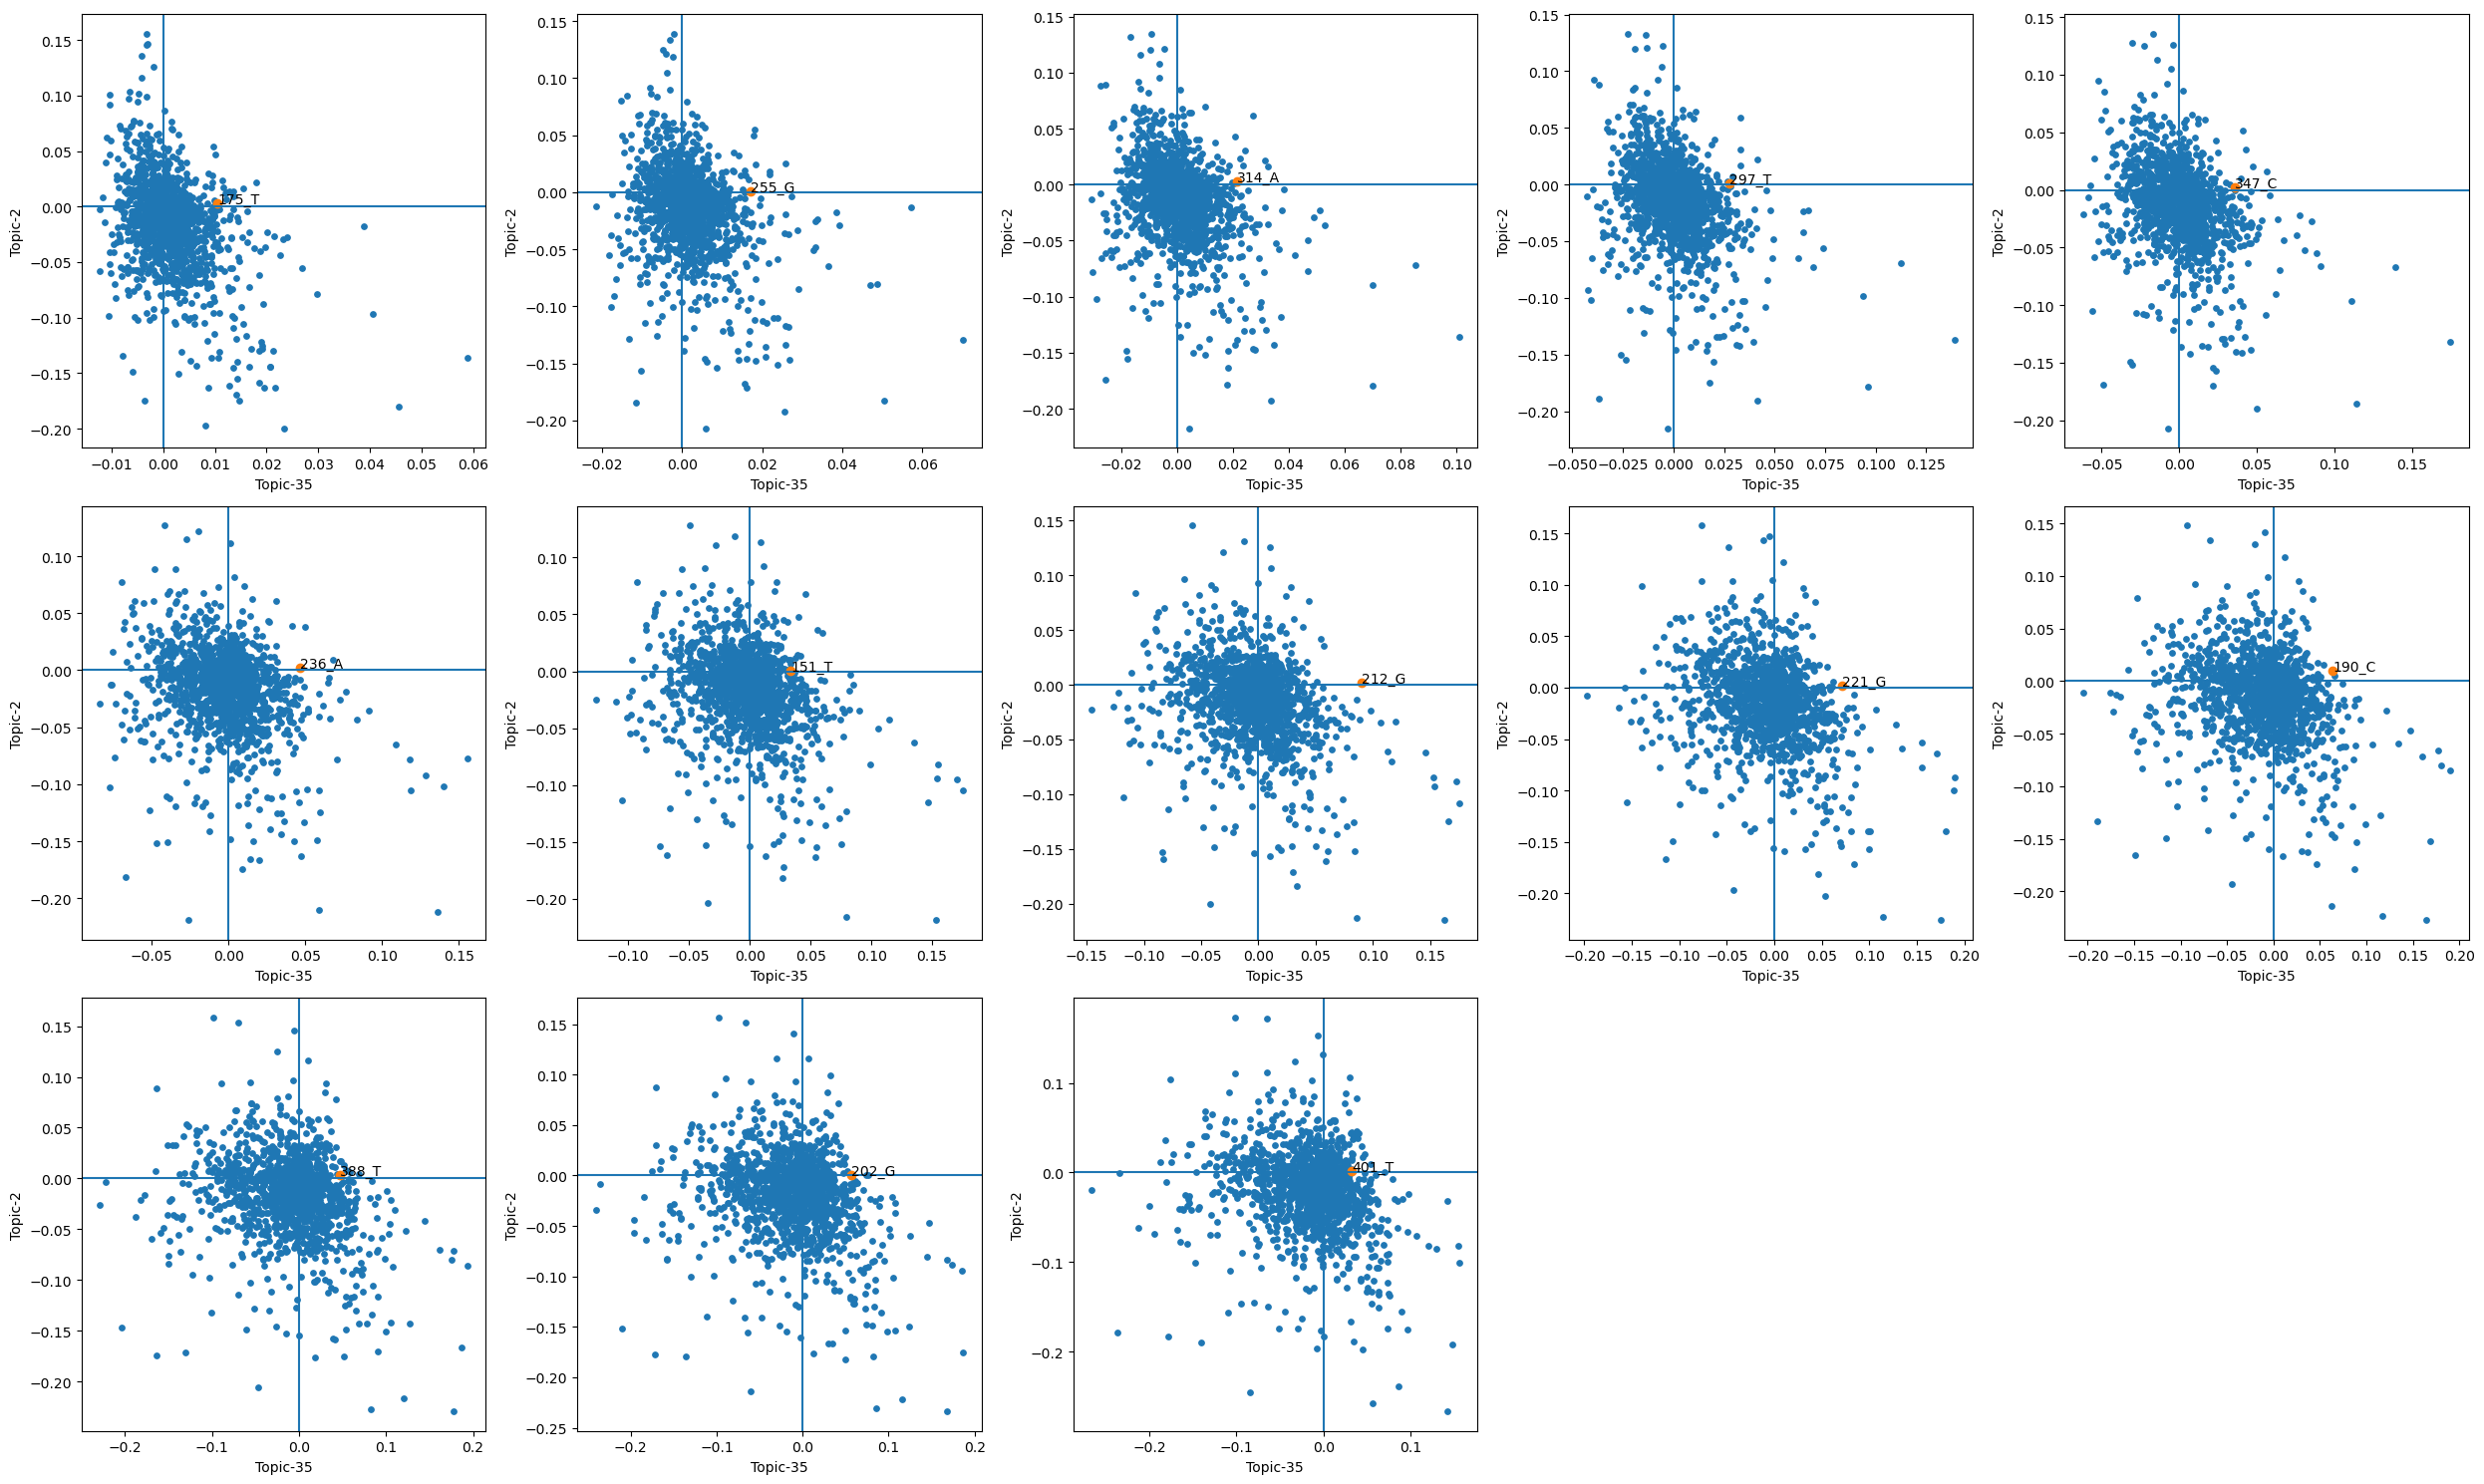

In [25]:
name = enh_name["Enh_28"]
addition = 120
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])


fig = plt.figure(figsize=(25,15))

for i,next_one in enumerate(["175_T","255_G","314_A","297_T","347_C","236_A","151_T","212_G","221_G","190_C","388_T","202_G","401_T"]):
    ax =  fig.add_subplot(3,5,i+1)
    
    mutagenesis_X = utils.create_saturation_mutagenesis_x(start_x)
    prediction_mutagenesis_X = model_dict["DeepFlyBrain"].predict(mutagenesis_X["X"])
    original_prediction = model_dict["DeepFlyBrain"].predict(start_x)
    
    plt.scatter(prediction_mutagenesis_X[:,34]-original_prediction[:,34],prediction_mutagenesis_X[:,1]-original_prediction[:,1],s=15)
    index = np.array(mutagenesis_X["ids"]) == next_one
    plt.scatter(prediction_mutagenesis_X[index,34]-original_prediction[:,34],prediction_mutagenesis_X[index,1]-original_prediction[:,1])
    plt.annotate(next_one, (prediction_mutagenesis_X[index,34]-original_prediction[:,34], prediction_mutagenesis_X[index,1]-original_prediction[:,1]))
    
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel("Topic-35")
    plt.ylabel("Topic-2")
    
    start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')

fig.tight_layout()
plt.savefig("figures/augmentation_pruning/Enh_28_addition120_predictions_each_step.pdf",transparent=True)

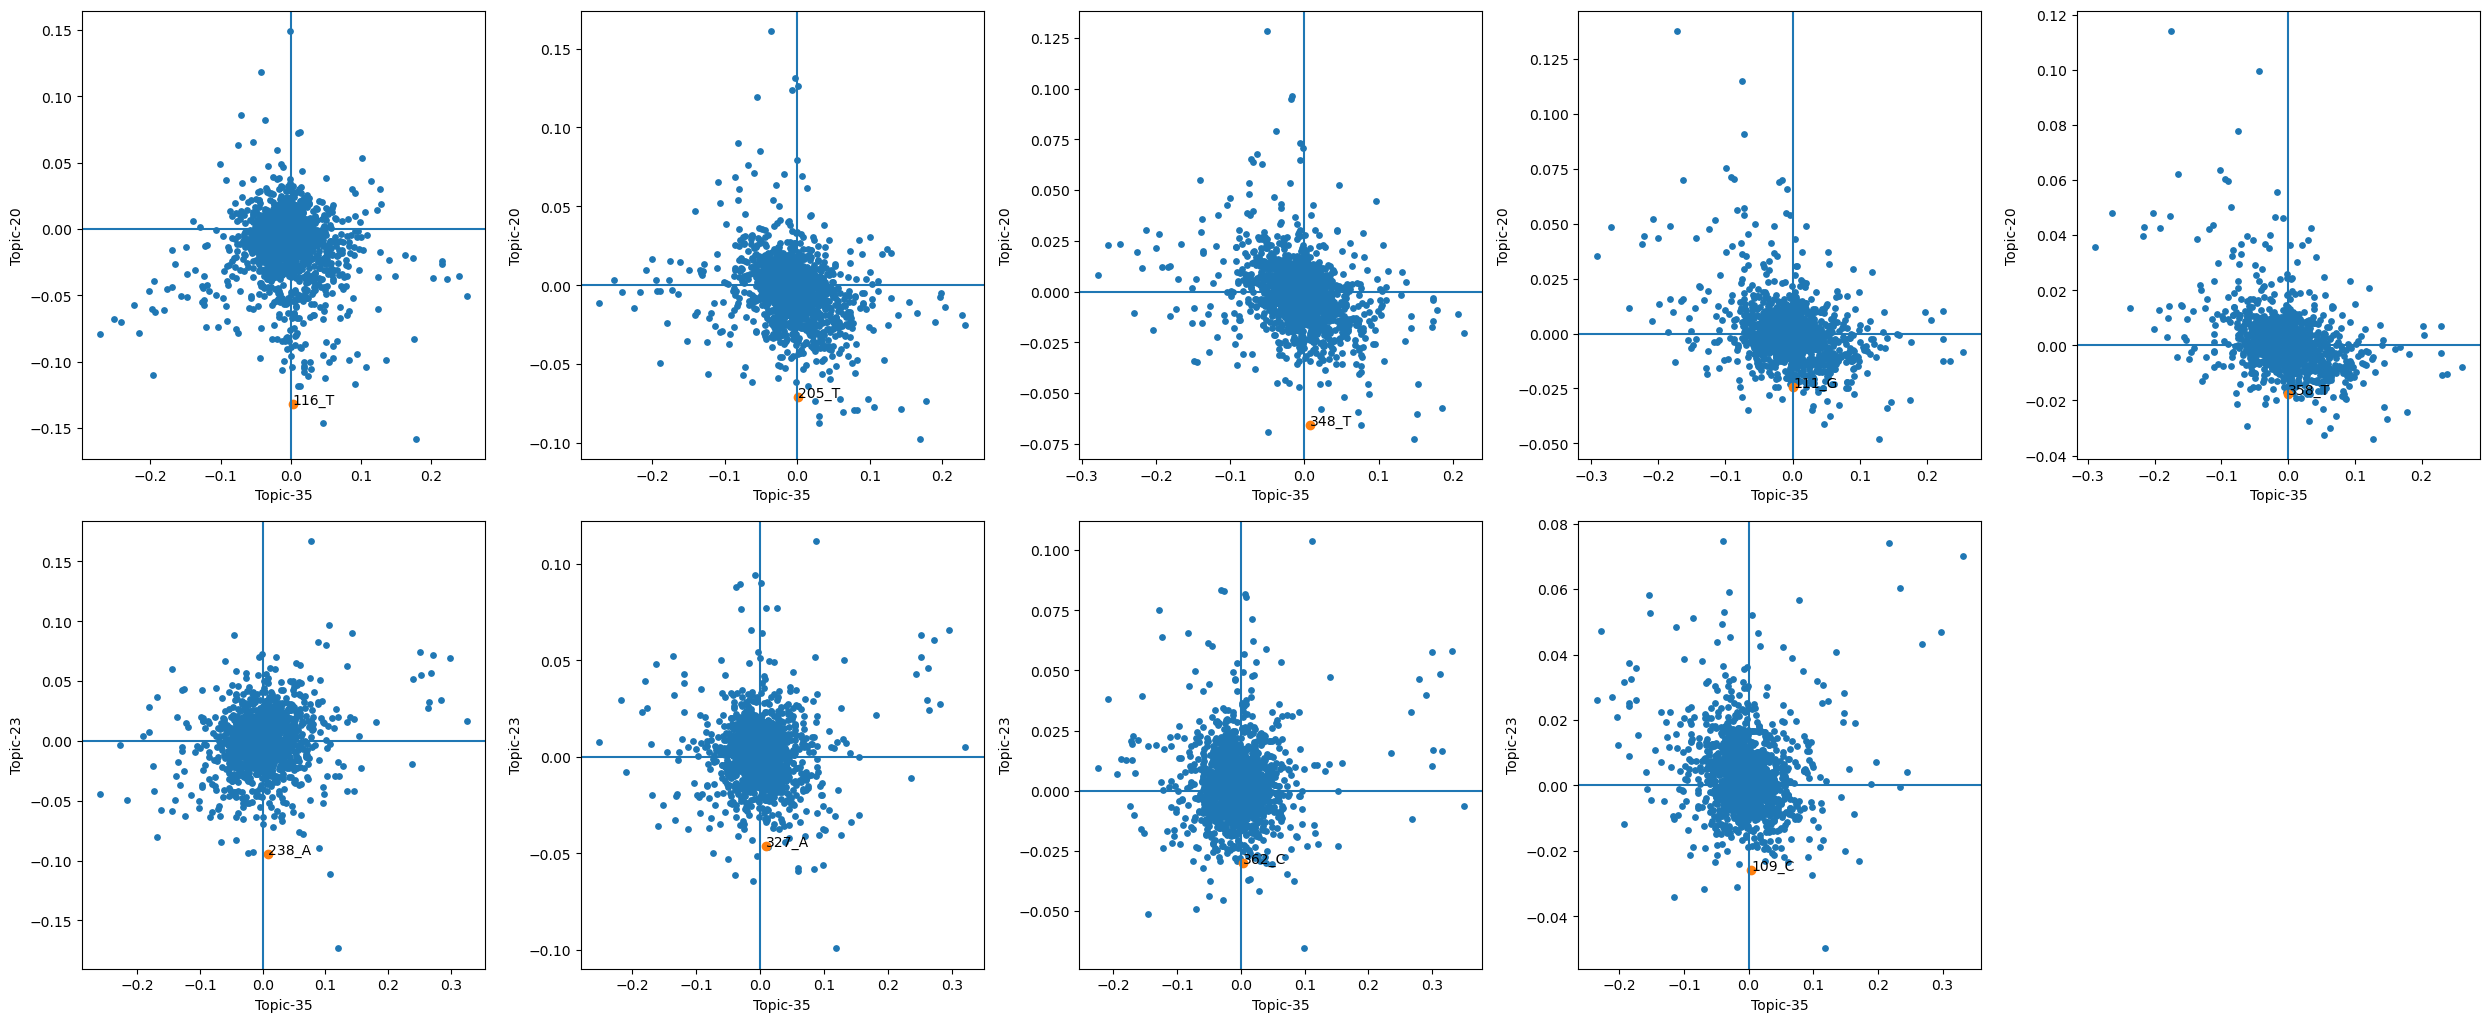

In [26]:
name = enh_name["Enh_41"]
addition = 378
start_x  = np.copy(cloned_enhancers_dict["X"][ np.argwhere( cloned_enhancers_dict["ids"] == name)[0][0]][:,addition:addition+500])


fig = plt.figure(figsize=(25,15))

for i,next_one in enumerate(["116_T","205_T","348_T","111_G","358_T","238_A","327_A","362_C","109_C"]):
    ax =  fig.add_subplot(3,5,i+1)
    
    mutagenesis_X = utils.create_saturation_mutagenesis_x(start_x)
    prediction_mutagenesis_X = model_dict["DeepFlyBrain"].predict(mutagenesis_X["X"])
    original_prediction = model_dict["DeepFlyBrain"].predict(start_x)

    if i >4:
        topic_ = 22
    else:
        topic_ = 19
    plt.scatter(prediction_mutagenesis_X[:,34]-original_prediction[:,34],prediction_mutagenesis_X[:,topic_]-original_prediction[:,topic_],s=15)
    index = np.array(mutagenesis_X["ids"]) == next_one
    plt.scatter(prediction_mutagenesis_X[index,34]-original_prediction[:,34],prediction_mutagenesis_X[index,topic_]-original_prediction[:,topic_])
    plt.annotate(next_one, (prediction_mutagenesis_X[index,34]-original_prediction[:,34], prediction_mutagenesis_X[index,topic_]-original_prediction[:,topic_]))
    
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel("Topic-35")
    plt.ylabel("Topic-"+str(topic_+1))
    
    start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')

fig.tight_layout()
plt.savefig("figures/augmentation_pruning/Enh_41_addition378_predictions_each_step.pdf",transparent=True)